# Prediction notebook

This notebook allows replicating the figures and showcase how predictions can be made from the trained networks.

# Library loading and additional function definition

In [1]:
%matplotlib inline

# dataframes and arrays
import pandas as pd 
import numpy as np

# for plotting
import matplotlib.pyplot as plt 
import matplotlib, mpltern, corner
from mpltern.ternary.datasets import get_spiral
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import matplotlib.gridspec as gridspec

# spearman corr coef
from scipy.stats import spearmanr

# mse
from sklearn.metrics import mean_squared_error

# neuravi internals
import neuravi

# other essentials
import torch, time, h5py

# we will work on CPU there
device = torch.device('cpu') #get_default_device()
print(device)

###
### Functions for ternary plots (not really needed with mpltern)
###

def polycorners(ncorners=3):
    '''
    Return 2D cartesian coordinates of a regular convex polygon of a specified
    number of corners.
    Args:
        ncorners (int, optional) number of corners for the polygon (default 3).
    Returns:
        (ncorners, 2) np.ndarray of cartesian coordinates of the polygon.
    '''

    center = np.array([0.5, 0.5])
    points = []

    for i in range(ncorners):
        angle = (float(i) / ncorners) * (np.pi * 2) + (np.pi / 2)
        x = center[0] + np.cos(angle) * 0.5
        y = center[1] + np.sin(angle) * 0.5
        points.append(np.array([x, y]))

    return np.array(points)

def bary2cart(bary, corners):
    '''
    Convert barycentric coordinates to cartesian coordinates given the
    cartesian coordinates of the corners.
    Args:
        bary (np.ndarray): barycentric coordinates to convert. If this matrix
            has multiple rows, each row is interpreted as an individual
            coordinate to convert.
        corners (np.ndarray): cartesian coordinates of the corners.
    Returns:
        2-column np.ndarray of cartesian coordinates for each barycentric
        coordinate provided.
    '''

    cart = None

    if len(bary.shape) > 1 and bary.shape[1] > 1:
        cart = np.array([np.sum(b / np.sum(b) * corners.T, axis=1) for b in bary])
    else:
        cart = np.sum(bary / np.sum(bary) * corners.T, axis=1)

    return cart


cpu


# Load dataset

In [2]:
path_data = "./data/DataSet_0p20val.hdf5"
path_raman = "./data/NKAS_Raman.hdf5"
path_density = "./data/NKAS_density.hdf5"
path_optical = "./data/NKAS_optical.hdf5"

ds = neuravi.data_loader(path_data,path_raman,path_density,path_optical,device)


/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


# Function to bag models

This object will help bagging results from 10 models and calling their predictions.

In [3]:
class models:
    """custom global model predictions

    """
    def __init__(self, path, name_models, device):
        
        self.device = device
        self.n_models = len(name_models)
        self.models = [None for _ in range(self.n_models)]
        
        for i in range(self.n_models):
            name = name_models[i]
            
            # Extract arch
            nb_layers = int(name[name.find("l")+1:name.find("_n")])
            nb_neurons = int(name[name.find("n")+1:name.rfind("_p")])
            p_drop = float(name[name.find("p")+1:name.rfind(".")])
            
            self.models[i] = neuravi.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 
            self.models[i].load_state_dict(torch.load(path+name,map_location='cpu'))
            self.models[i].eval()
            
    def predict(self,method,X, T=[1000.0], lbd= [500.0]):
        
        X = torch.Tensor(X).to(self.device)
        T = torch.Tensor(T).to(self.device)
        lbd = torch.Tensor(lbd).to(self.device)
        
        if method == "raman_pred":    
            out = np.zeros((len(X),850,self.n_models)) # problem is defined with a X raman shift of 850 values
            for i in range(self.n_models):
                out[:,:,i] = getattr(self.models[i],method)(X).cpu().detach().numpy()
            return out
        else:
            out = np.zeros((len(X),self.n_models))
            
        if method in frozenset(('ag', 'myega', 'am', 'cg', 'tvf')):
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X,T).cpu().detach().numpy().reshape(-1)
        elif method == "sellmeier":
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X,lbd).cpu().detach().numpy().reshape(-1)           
        else:
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X).cpu().detach().numpy().reshape(-1)
        
        return out
                    

# Loading the models

In [4]:
path = "./model/best/"
name_list = pd.read_csv("./model/best/best_list.csv").loc[:,"name"]
neuralmodel = models(path, name_list, device)

# Root-mean-squared-errors calculations

Between all datasets and their predictions.

In [5]:
criterion = torch.nn.MSELoss()

y_ag_train = neuralmodel.predict("ag",ds.x_visco_train,ds.T_visco_train)
y_ag_valid = neuralmodel.predict("ag",ds.x_visco_valid,ds.T_visco_valid)
y_ag_test = neuralmodel.predict("ag",ds.x_visco_test,ds.T_visco_test)

y_tvf_train = neuralmodel.predict("tvf",ds.x_visco_train,ds.T_visco_train)
y_tvf_valid = neuralmodel.predict("tvf",ds.x_visco_valid,ds.T_visco_valid)
y_tvf_test = neuralmodel.predict("tvf",ds.x_visco_test,ds.T_visco_test)

y_myega_train = neuralmodel.predict("myega",ds.x_visco_train,ds.T_visco_train)
y_myega_valid = neuralmodel.predict("myega",ds.x_visco_valid,ds.T_visco_valid)
y_myega_test = neuralmodel.predict("myega",ds.x_visco_test,ds.T_visco_test)

y_am_train = neuralmodel.predict("am",ds.x_visco_train,ds.T_visco_train)
y_am_valid = neuralmodel.predict("am",ds.x_visco_valid,ds.T_visco_valid)
y_am_test = neuralmodel.predict("am",ds.x_visco_test,ds.T_visco_test)

y_cg_train = neuralmodel.predict("cg",ds.x_visco_train,ds.T_visco_train)
y_cg_valid = neuralmodel.predict("cg",ds.x_visco_valid,ds.T_visco_valid)
y_cg_test = neuralmodel.predict("cg",ds.x_visco_test,ds.T_visco_test)

ag_after_train = np.sqrt(mean_squared_error(y_ag_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
ag_after_valid = np.sqrt(mean_squared_error(y_ag_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
ag_after_test = np.sqrt(mean_squared_error(y_ag_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('AG train loss after training {0:.2f}'.format(ag_after_train))
print('AG valid loss after training {0:.2f}'.format(ag_after_valid))
print('AG test loss after training {0:.2f}'.format(ag_after_test))
print('')

tvf_after_train = np.sqrt(mean_squared_error(y_tvf_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
tvf_after_valid = np.sqrt(mean_squared_error(y_tvf_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
tvf_after_test  = np.sqrt(mean_squared_error(y_tvf_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('TVF train loss after training {0:.2f}'.format(tvf_after_train))
print('TVF valid loss after training {0:.2f}'.format(tvf_after_valid))
print('TVF test loss after training {0:.2f}'.format(tvf_after_test))
print('')

myega_after_train = np.sqrt(mean_squared_error(y_myega_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
myega_after_valid = np.sqrt(mean_squared_error(y_myega_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
myega_after_test = np.sqrt(mean_squared_error(y_myega_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('myega train loss after training {0:.2f}'.format(myega_after_train))
print('myega valid loss after training {0:.2f}'.format(myega_after_valid))
print('myega test loss after training {0:.2f}'.format(myega_after_test))
print('')

am_after_train = np.sqrt(mean_squared_error(y_am_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
am_after_valid = np.sqrt(mean_squared_error(y_am_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
am_after_test = np.sqrt(mean_squared_error(y_am_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('am train loss after training {0:.2f}'.format(am_after_train))
print('am valid loss after training {0:.2f}'.format(am_after_valid))
print('am test loss after training {0:.2f}'.format(am_after_test))
print('')

cg_after_train = np.sqrt(mean_squared_error(y_cg_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
cg_after_valid = np.sqrt(mean_squared_error(y_cg_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
cg_after_test = np.sqrt(mean_squared_error(y_cg_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('cg train loss after training {0:.2f}'.format(cg_after_train))
print('cg valid loss after training {0:.2f}'.format(cg_after_valid))
print('cg test loss after training {0:.2f}'.format(cg_after_test))
print('')

# Now we calculate on density and refractive index
ese_density_train = np.sqrt(mean_squared_error(ds.y_density_train.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_train).mean(axis=1)))
ese_density_valid = np.sqrt(mean_squared_error(ds.y_density_valid.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_valid).mean(axis=1)))
ese_density_test = np.sqrt(mean_squared_error(ds.y_density_test.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_test).mean(axis=1)))

ese_ri_train = np.sqrt(mean_squared_error(ds.y_ri_train.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_train,lbd=ds.lbd_ri_train).mean(axis=1)))
ese_ri_valid = np.sqrt(mean_squared_error(ds.y_ri_valid.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_valid,lbd=ds.lbd_ri_valid).mean(axis=1)))
ese_ri_test = np.sqrt(mean_squared_error(ds.y_ri_test.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_test,lbd=ds.lbd_ri_test).mean(axis=1)))

print('density train loss after training {0:.3f}'.format(ese_density_train))
print('density valid loss after training {0:.3f}'.format(ese_density_valid))
print('density test loss after training {0:.3f}'.format(ese_density_test))
print('')

print('refractive index train loss after training {0:.3f}'.format(ese_ri_train))
print('refractive index valid loss after training {0:.3f}'.format(ese_ri_valid))
print('refractive index test loss after training {0:.3f}'.format(ese_ri_test))
print('')


AG train loss after training 0.25
AG valid loss after training 0.30
AG test loss after training 0.46

TVF train loss after training 0.24
TVF valid loss after training 0.35
TVF test loss after training 0.45

myega train loss after training 0.25
myega valid loss after training 0.39
myega test loss after training 0.46

am train loss after training 0.24
am valid loss after training 0.36
am test loss after training 0.46

cg train loss after training 0.22
cg valid loss after training 0.36
cg test loss after training 0.45

density train loss after training 0.007
density valid loss after training 0.014
density test loss after training 0.009

refractive index train loss after training 0.003
refractive index valid loss after training 0.003
refractive index test loss after training 0.005



# Figure 2

This figure presents viscosity predictions for melts with ~66 mol% silica and different Al/Si ratios.

In [6]:
#
# For simplicity, data were saved in an external file
# we load it below
#
df2 = pd.read_csv("./data/data_for_post_analyses.csv")
silica = df2.loc[df2.ref=="H1964&U1982",:].reset_index()
nks = df2.loc[df2.ref=="see LL2017b",:].reset_index()
Jd = df2.loc[df2.ref=="R2019",:].reset_index()
NAK6509 = df2.loc[df2.ref=="TS",:].reset_index()

#
# We define utility functions to do the figure below
#
def plot_viscocurve(ax,dts,method = "ag",color="k",marker="s",linestyle="-"):
    """plot viscosity predictions given some arguments"""
    x_inter = np.arange(dts.loc[:,"T_K"].min()-50,dts.loc[:,"T_K"].max()+50,1.0)
    if dts.loc[0,"sio2"] > 1:
        ax.plot(x_inter,
                 neuralmodel.predict(method,
                                     torch.Tensor(dts.loc[0,"sio2":"k2o"].values.astype('float')*np.ones((len(x_inter),4))/100).to(device),
                                     torch.Tensor(x_inter.reshape(-1,1)).to(device)).mean(axis=1),
                color=color, linestyle=linestyle, linewidth=1,
            )
    else:
        ax.plot(x_inter,
                 neuralmodel.predict(method,
                                     torch.Tensor(dts.loc[0,"sio2":"k2o"].values.astype('float')*np.ones((len(x_inter),4))).to(device),
                                     torch.Tensor(x_inter.reshape(-1,1)).to(device)).mean(axis=1),
                color=color, linestyle=linestyle, linewidth=1,
            )
    return ax

def prepare_data_fig2(neuralmodel,sio2,al2o3,alkalis, xk_ = np.arange(0,1,0.01), T_ = np.arange(650,2000,1.0)):
    """prepare xk mapping for surface plot of figure 2"""
    xk_plot = []
    T_plot = []
    for count,value in enumerate(xk_):
        X__ = np.vstack([sio2*np.ones(len(T_)),
                         al2o3*np.ones(len(T_)),
                         alkalis*(1-value*np.ones(len(T_))),
                         alkalis*value*np.ones(len(T_))]).T
        if count == 0:
            xk_plot = value*np.ones(len(T_))
            T_plot = T_.copy()
            n_plot = neuralmodel.predict("cg",X__,np.array(T_).reshape(-1,1)).mean(axis=-1)
        else:
            xk_plot = np.vstack((xk_plot,value*np.ones(len(T_))))
            T_plot = np.vstack((T_plot,T_))
            n_plot = np.vstack((n_plot,neuralmodel.predict("ag",X__,np.array(T_).reshape(-1,1)).mean(axis=-1)))
    
    return xk_plot, T_plot, n_plot



In [7]:
#
# now we prepare the different datasets
# this is useful if one wants to visualize the 3D plot below and can be commented if not, as it is slow.
#
xk_plot_NKS, T_plot_NKS, n_plot_NKS  = prepare_data_fig2(neuralmodel,0.67,0.0,0.33)
xk_plot_Jad, T_plot_Jad, n_plot_Jad = prepare_data_fig2(neuralmodel,0.67,0.165,0.165,T_ = np.arange(1050,2000,1.0))
xk_plot_6509, T_plot_6509, n_plot_6509 = prepare_data_fig2(neuralmodel,0.66,0.09,0.25,T_ = np.arange(750,2000,1.0))

### Figure 2 generation

Markers are data. Dashed lines are AG predictions. Solid lines are CG predictions.

In [8]:
plt.figure(figsize=(3.22,7),dpi=200)
ax = plt.subplot(2,1,2)
ax2 = plt.subplot(2,1,1)

#
# data
#
ax.plot(Jd[Jd.Name == "Jd100"].T_K,Jd[Jd.Name == "Jd100"].viscosity,"s",ms=4,color="firebrick",label="NaAlSi$_2$O$_6$")
ax.plot(Jd[Jd.Name == "Jd50"].T_K,Jd[Jd.Name == "Jd50"].viscosity,"d",ms=4,color="indianred",label="Na$_{0.5}$K$_{0.5}$AlSi$_2$O$_6$")
ax.plot(Jd[Jd.Name == "Jd0"].T_K,Jd[Jd.Name == "Jd0"].viscosity,"^",ms=4,color="maroon",label="KAlSi$_2$O$_6$")
ax.plot(NAK6509[NAK6509.Name == "NA65_9"].T_K,NAK6509[NAK6509.Name == "NA65_9"].viscosity,
        "s",ms=4,color="orange",label="Na$_3$AlSi$_4$O$_{11}$")
ax.plot(NAK6509[NAK6509.Name == "KA65_9"].T_K,NAK6509[NAK6509.Name == "KA65_9"].viscosity,
        "^",ms=4,color="darkorange",label="K$_3$AlSi$_4$O$_{11}$")

ax2.plot(silica.T_K,silica.viscosity,"o",ms=4,color="black",label="SiO$_2$")
ax2.plot(nks[nks.Name == "NS66"].T_K,nks[nks.Name == "NS66"].viscosity,"s",ms=4,color="indigo",label="NaSi$_2$O$_5$")
ax2.plot(nks[nks.Name == "NKS66_17"].T_K,nks[nks.Name == "NKS66_17"].viscosity,"d",ms=4,color="blue",label="Na$_{0.5}$K$_{0.5}$Si$_2$O$_5$")
ax2.plot(nks[nks.Name == "KS66"].T_K,nks[nks.Name == "KS66"].viscosity,"^",ms=4,color="navy",label="KSi$_2$O$_5$")

ax.legend(fontsize=7)
ax2.legend(fontsize=7)

plot_viscocurve(ax, Jd[Jd.Name == "Jd100"].reset_index(),method = "cg",color="firebrick")
plot_viscocurve(ax, Jd[Jd.Name == "Jd50"].reset_index(),method = "cg",color="indianred")
plot_viscocurve(ax, Jd[Jd.Name == "Jd0"].reset_index(),method = "cg",color="maroon")
plot_viscocurve(ax, Jd[Jd.Name == "Jd100"].reset_index(),method = "ag",linestyle="--",color="firebrick")
plot_viscocurve(ax, Jd[Jd.Name == "Jd50"].reset_index(),method = "ag",linestyle="--",color="indianred")
plot_viscocurve(ax, Jd[Jd.Name == "Jd0"].reset_index(),method = "ag",linestyle="--",color="maroon")

plot_viscocurve(ax, NAK6509[NAK6509.Name == "NA65_9"].reset_index(),method = "ag",linestyle="--",color="orange")
plot_viscocurve(ax, NAK6509[NAK6509.Name == "KA65_9"].reset_index(),method = "ag",linestyle="--",color="darkorange")
plot_viscocurve(ax, NAK6509[NAK6509.Name == "NA65_9"].reset_index(),method = "cg",linestyle="-",color="orange")
plot_viscocurve(ax, NAK6509[NAK6509.Name == "KA65_9"].reset_index(),method = "cg",linestyle="-",color="darkorange")

#
# Top subplot
#

plot_viscocurve(ax2, silica,method = "cg",color="black")
plot_viscocurve(ax2, nks[nks.Name == "NS66"].reset_index(),method = "cg",color="indigo")
plot_viscocurve(ax2, nks[nks.Name == "NKS66_17"].reset_index(),method = "cg",color="blue")
plot_viscocurve(ax2, nks[nks.Name == "KS66"].reset_index(),method = "cg",color="navy")
plot_viscocurve(ax2, silica,method = "ag",linestyle="--",color="black")
plot_viscocurve(ax2, nks[nks.Name == "NS66"].reset_index(),method = "ag",linestyle="--",color="indigo")
plot_viscocurve(ax2, nks[nks.Name == "NKS66_17"].reset_index(),method = "ag",linestyle="--",color="blue")
plot_viscocurve(ax2, nks[nks.Name == "KS66"].reset_index(),method = "ag",linestyle="--",color="navy")

# axes labels
ax.set_ylabel("Viscosity, log Pa$\cdot$s")
ax2.set_ylabel("Viscosity, log Pa$\cdot$s")
ax.set_xlabel("Temperature, K")

# annotations
ax.annotate("B)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
ax2.annotate("A)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

# set axes
ax.set_ylim(-1,18)
ax2.set_ylim(-1,18)

plt.tight_layout()

plt.savefig("./figures/Figure2_new.png")

### Notebook figure : fancy 3D Plot and histograms of errors

Viscosity are predicted with the AG and CG equations.

In [9]:
#
# the plot occur below
# note that you can switch the line below to %matplotlib notebook if you want an interactive plot
#
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(constrained_layout=True,figsize=(7,6),dpi=150)

spec2 = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)
ax = fig.add_subplot(spec2[:, 0:2], projection = "3d")
ax2 = fig.add_subplot(spec2[0, 2])
ax3 = fig.add_subplot(spec2[1, 2])

ax.plot(nks.k2o/(nks.k2o+nks.na2o),
        10000/nks.T_K,nks.viscosity,color="blue",marker="d",markerfacecolor="none",linestyle="",
        markersize = 3,label="(Na$_{1-X_K}$K$_{X_K}$)$_2$Si$_2$O$_5$")

ax.plot(NAK6509.k2o/(NAK6509.k2o+NAK6509.na2o),
        10000/NAK6509.T_K,NAK6509.viscosity,color="orange",marker="o",markerfacecolor="none",linestyle="",
        markersize = 3,label="(Na$_{1-X_K}$K$_{X_K}$)$_{1.63}$Al$_{0.49}$Si$_{1.79}}$O$_5$")

ax.plot(Jd.k2o/(Jd.k2o+Jd.na2o),
        10000/Jd.T_K,Jd.viscosity,color="green",marker="s",markerfacecolor="none",linestyle="",
        markersize = 3,label="(Na$_{1-X_K}$K$_{X_K}$)AlSi$_2$O$_6$")

ax.plot_surface(xk_plot_NKS,10000/T_plot_NKS,n_plot_NKS, alpha=0.3, cmap='Blues')
ax.plot_surface(xk_plot_Jad,10000/T_plot_Jad,n_plot_Jad, alpha=0.5, cmap='summer')
ax.plot_surface(xk_plot_6509,10000/T_plot_6509,n_plot_6509, alpha=0.3, cmap='hot')

ax.plot_wireframe(xk_plot_NKS,10000/T_plot_NKS,n_plot_NKS, color = "b", alpha=0.1 , rstride=10, cstride=40)
ax.plot_wireframe(xk_plot_Jad,10000/T_plot_Jad,n_plot_Jad, color = "green", alpha=0.1, rstride=10, cstride=40, cmap='summer')
ax.plot_wireframe(xk_plot_6509,10000/T_plot_6509,n_plot_6509, color = "orange", alpha=0.1, rstride=10, cstride=40, cmap='hot')

ax.set_ylabel("10000/T, K$^{-1}$")
ax.set_xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
ax.set_zlabel("$\eta$, log Pa$\cdot$s")

ax2.hist(y_ag_train.mean(axis=1)-ds.y_visco_train.detach().numpy().ravel(),bins=20,alpha=0.3,density=True,
         label="Training")
ax2.hist(y_ag_valid.mean(axis=1)-ds.y_visco_valid.detach().numpy().ravel(),bins=20,alpha=0.3,density=True,
         label="Validation")
ax2.hist(y_ag_test.mean(axis=1)-ds.y_visco_test.detach().numpy().ravel(),bins=20,alpha=0.3,density=True,
         label="Testing")
ax2.set_xlim(-2,2)

ax3.hist(y_cg_train.mean(axis=1)-ds.y_visco_train.detach().numpy().ravel(),
         bins=20,alpha=0.3,density=True,label="Train.")
ax3.hist(y_cg_valid.mean(axis=1)-ds.y_visco_valid.detach().numpy().ravel(),
         bins=20,alpha=0.3,density=True,label="Valid.")
ax3.hist(y_cg_test.mean(axis=1)-ds.y_visco_test.detach().numpy().ravel(),
         bins=20,alpha=0.3,density=True,label="Test.")
ax3.set_xlim(-2,2)

ax3.set_xlabel("model - measures, log Pa$\cdot$s")
ax2.set_ylabel("Number of observations (normalized)")
ax3.set_ylabel("Number of observations (normalized)")

ax2.set_ylim(0,3.5)
ax3.set_ylim(0,3.5)

ax.annotate("A)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
#ax2.title("B) AG - Adam-Gibbs ",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
#ax3.title("C) CG - Free Volume ",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
ax2.set_title("B) Adam-Gibbs (eq. 1)",fontsize=10)
ax3.set_title("C) Free Volume (eq. 2) ",fontsize=10)

ax.view_init(20, 210)

plt.tight_layout()

ax.legend(loc="best")
ax2.legend(loc="best")


/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


# Supplementary figure: comparison of viscosity predictions from all equations

This cell generates the code for the figure that compares measurements and predictions (from the 5 equations) for viscosity.

In [10]:
plt.figure(figsize=(9,6),dpi=300)

plt.subplot(2,3,1)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_ag_train.mean(axis=1),marker="s",s=2,alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_ag_valid.mean(axis=1),marker="o",s=2,alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_ag_test.mean(axis=1),marker="d",s=2,alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2)

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))

plt.xlabel("$\eta$ measured, log Pa$\cdot$s")
plt.ylabel("$\eta$ predicted, log Pa$\cdot$s")

plt.annotate("A) Adam-Gibbs",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,3,4)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_myega_train.mean(axis=1),marker="s",s=2,alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_myega_valid.mean(axis=1),marker="o",s=2,alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_myega_test.mean(axis=1),marker="d",s=2,alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))
plt.xlabel("$\eta$ measured, log Pa$\cdot$s")
plt.ylabel("$\eta$ predicted, log Pa$\cdot$s")
plt.annotate("C) MYEGA",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,3,5)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_am_train.mean(axis=1),marker="s",s=2,alpha=0.3,label="Training data subset")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_am_valid.mean(axis=1),marker="o",s=2,alpha=0.3,label="Validation data subset\n(used to stop training)")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_am_test.mean(axis=1),marker="d",s=2,alpha=0.3,label="Testing data subset\n(never seen during training)")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))

plt.xlabel("$\eta$ measured, log Pa$\cdot$s")
plt.ylabel("$\eta$ predicted, log Pa$\cdot$s")
plt.annotate("D) Avramov-Milchev ",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,3,6)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_tvf_train.mean(axis=1),marker="s",s=2,alpha=0.3,label="Training data subset")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_tvf_valid.mean(axis=1),marker="o",s=2,alpha=0.3,label="Validation data subset\n(used to stop training)")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_tvf_test.mean(axis=1),marker="d",s=2,alpha=0.3,label="Testing data subset\n(never seen during training)")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))

plt.xlabel("$\eta$ measured, log Pa$\cdot$s")
plt.ylabel("$\eta$ predicted, log Pa$\cdot$s")
plt.annotate("E) TVF ",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,3,2)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_cg_train.mean(axis=1),marker="s",s=2,alpha=0.3,
            label="Training subset")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_cg_valid.mean(axis=1),marker="o",s=2,alpha=0.3,
            label="Validation subset")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_cg_test.mean(axis=1),marker="d",s=2,alpha=0.3,
            label="Testing subset")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))

plt.xlabel("$\eta$ measured, log Pa$\cdot$s")
plt.ylabel("$\eta$ predicted, log Pa$\cdot$s")
plt.annotate("B) CG - Free Volume ",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.tight_layout()

plt.legend(fontsize=12, bbox_to_anchor=(1.1,0.7))

plt.savefig("./figures/Supp_compvisco.png")

# Notebook figure: behavior at fixed Al/M ratios

This figure allows us to perform a visual inspection > predicted entropy and fragility should vary smoothly.

Checking shape...
(50, 4)


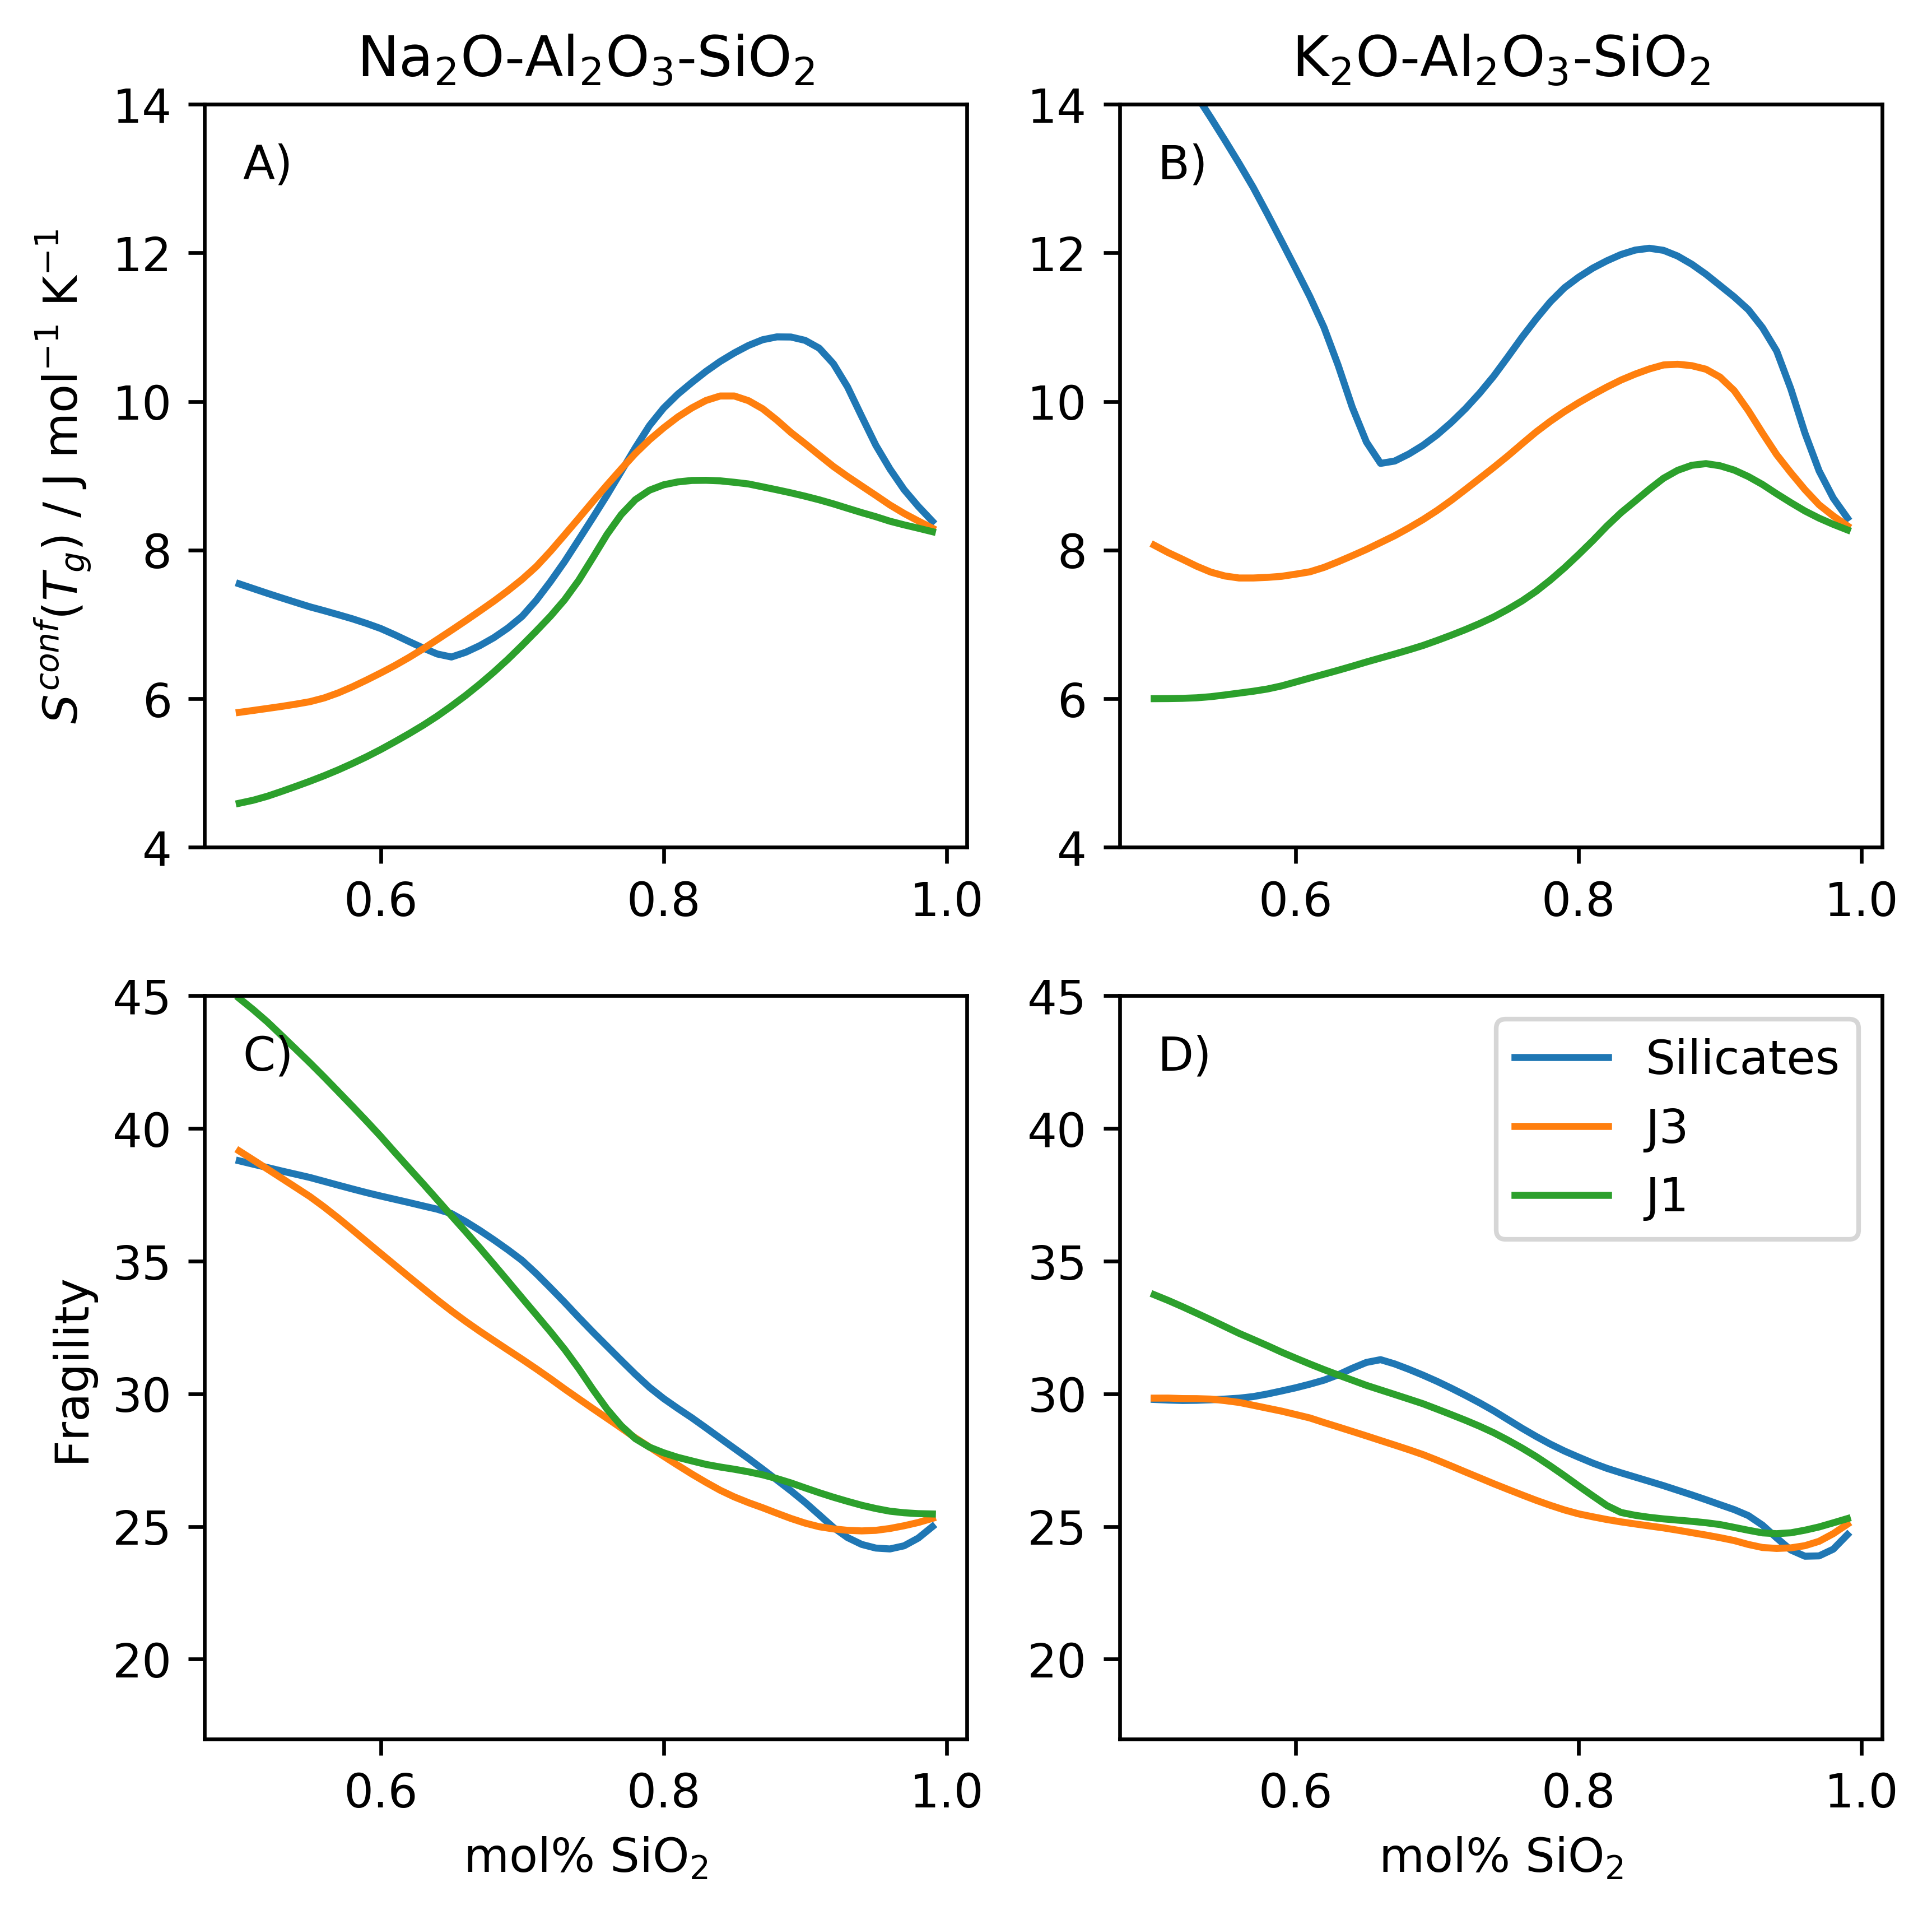

In [11]:
sio2 = np.arange(0.5,1.,0.01)

# order => sio2 al2o3 na2o k2o
X_visu_NAS_sili = np.vstack([sio2,np.zeros(len(sio2)),1.0-sio2,np.zeros(len(sio2))]).T
X_visu_NAS_J3 = np.vstack([sio2,(1.0-sio2)*1.0/3.0, (1.0-sio2)*2.0/3.0,np.zeros(len(sio2))]).T
X_visu_NAS_J1 = np.vstack([sio2,(1.0-sio2)*0.5, (1.0-sio2)*0.5,np.zeros(len(sio2))]).T

X_visu_KAS_sili = np.vstack([sio2,np.zeros(len(sio2)),np.zeros(len(sio2)),1.0-sio2]).T
X_visu_KAS_J3 = np.vstack([sio2,(1.0-sio2)*1.0/3.0,np.zeros(len(sio2)), (1.0-sio2)*2.0/3.0]).T
X_visu_KAS_J1 = np.vstack([sio2,(1.0-sio2)*0.5,np.zeros(len(sio2)), (1.0-sio2)*0.5]).T

Sctg_NAS_sili = neuralmodel.predict("sctg",X_visu_NAS_sili).mean(axis=1)
Sctg_NAS_J3 = neuralmodel.predict("sctg",X_visu_NAS_J3).mean(axis=1)
Sctg_NAS_J1 = neuralmodel.predict("sctg",X_visu_NAS_J1).mean(axis=1)

Sctg_KAS_sili = neuralmodel.predict("sctg",X_visu_KAS_sili).mean(axis=1)
Sctg_KAS_J3 = neuralmodel.predict("sctg",X_visu_KAS_J3).mean(axis=1)
Sctg_KAS_J1 = neuralmodel.predict("sctg",X_visu_KAS_J1).mean(axis=1)

tg_NAS_sili = neuralmodel.predict("tg",X_visu_NAS_sili).mean(axis=1)
tg_NAS_J3 = neuralmodel.predict("tg",X_visu_NAS_J3).mean(axis=1)
tg_NAS_J1 = neuralmodel.predict("tg",X_visu_NAS_J1).mean(axis=1)

tg_KAS_sili = neuralmodel.predict("tg",X_visu_KAS_sili).mean(axis=1)
tg_KAS_J3 = neuralmodel.predict("tg",X_visu_KAS_J3).mean(axis=1)
tg_KAS_J1 = neuralmodel.predict("tg",X_visu_KAS_J1).mean(axis=1)

m_NAS_sili = neuralmodel.predict("fragility",X_visu_NAS_sili).mean(axis=1)
m_NAS_J3 = neuralmodel.predict("fragility",X_visu_NAS_J3).mean(axis=1)
m_NAS_J1 = neuralmodel.predict("fragility",X_visu_NAS_J1).mean(axis=1)

m_KAS_sili = neuralmodel.predict("fragility",X_visu_KAS_sili).mean(axis=1)
m_KAS_J3 = neuralmodel.predict("fragility",X_visu_KAS_J3).mean(axis=1)
m_KAS_J1 = neuralmodel.predict("fragility",X_visu_KAS_J1).mean(axis=1)

print("Checking shape...")
print(X_visu_KAS_J1.shape)

plt.figure(figsize=(6.44,6.44), dpi=600)

plt.subplot(2,2,1) # NAS entropy

plt.plot(X_visu_NAS_sili[:,0],Sctg_NAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_NAS_J3[:,0],Sctg_NAS_J3,color="C1",label="J3")
plt.plot(X_visu_NAS_J1[:,0],Sctg_NAS_J1,color="C2",label="J1")

plt.title(r"Na$_2$O-Al$_2$O$_3$-SiO$_2$")
plt.ylabel("$S^{conf}(T_g)$ / J mol$^{-1}$ K$^{-1}$")
plt.annotate("A)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
plt.ylim(4,14)

plt.subplot(2,2,2) # KAS entropy

plt.plot(X_visu_KAS_sili[:,0],Sctg_KAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_KAS_J3[:,0],Sctg_KAS_J3,color="C1",label="J3")
plt.plot(X_visu_KAS_J1[:,0],Sctg_KAS_J1,color="C2",label="J1")

plt.title(r"K$_2$O-Al$_2$O$_3$-SiO$_2$")
plt.annotate("B)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
plt.ylim(4,14)

plt.subplot(2,2,3) # NAS fragility

plt.plot(X_visu_NAS_sili[:,0],m_NAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_NAS_J3[:,0],m_NAS_J3,color="C1",label="J3")
plt.plot(X_visu_NAS_J1[:,0],m_NAS_J1,color="C2",label="J1")

plt.xlabel("mol% SiO$_2$")
plt.ylabel("Fragility")
plt.annotate("C)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
plt.ylim(17,45)

plt.subplot(2,2,4) # KAS fragility

plt.plot(X_visu_KAS_sili[:,0],m_KAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_KAS_J3[:,0],m_KAS_J3,color="C1",label="J3")
plt.plot(X_visu_KAS_J1[:,0],m_KAS_J1,color="C2",label="J1")
plt.ylim(17,45)

plt.xlabel("mol% SiO$_2$")
plt.annotate("D)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.legend(loc="upper right")

# Supplementary figure: Raman spectra

We do this now because we need to have Raman spectra for Figures 4 and 5. They are generated below.

The code below allows us to predict Raman spectra corresponding to those in the training and validation.

Median of the Relative Least Absolute Deviation on Train Raman dataset is 18.44%
Median of the Relative Least Absolute Deviation on Valid Raman dataset is 22.10%


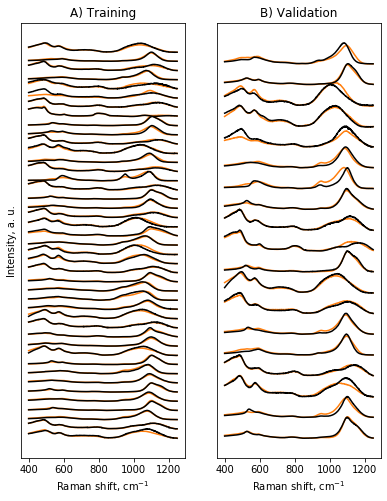

In [13]:
#
# our real x axis, for resampling
#

x_raman_shift = np.arange(400.,1250.,1.0)

#
# Predictions for Raman spectra
#

raman_train_predictions = neuralmodel.predict("raman_pred",ds.x_raman_train).mean(axis=2)
raman_valid_predictions = neuralmodel.predict("raman_pred",ds.x_raman_valid).mean(axis=2)

#
# Figure comparing Raman data to predictions
#

plt.figure(figsize=(6.44,8))

plt.subplot(1,2,1)
plt.title("A) Training")
Raman_error_train = np.zeros(ds.x_raman_train.shape[0])
shift = 0.
for i in range(ds.x_raman_train.shape[0]):
    Raman_error_train[i] = np.mean(np.abs(raman_train_predictions[i,:]-ds.y_raman_train[i,:].detach().numpy())/raman_train_predictions[i,:])
    plt.plot(x_raman_shift,raman_train_predictions[i,:]+shift,color="C1")
    plt.plot(x_raman_shift,ds.y_raman_train[i,:].detach().numpy()+shift,"k-")
    shift += 1.
plt.xlabel("Raman shift, cm$^{-1}$")
plt.ylabel("Intensity, a. u.")
plt.yticks([])

print("Median of the Relative Least Absolute Deviation on Train Raman dataset is {0:.2f}%".format(np.median(Raman_error_train)*100))

plt.subplot(1,2,2)
plt.title("B) Validation")
Raman_error_valid = np.zeros(ds.x_raman_valid.shape[0])
shift = 0.
for i in range(ds.x_raman_valid.shape[0]):
    Raman_error_valid[i] = np.mean(np.abs(raman_valid_predictions[i,:]-ds.y_raman_valid[i,:].detach().numpy())/raman_valid_predictions[i,:])
    plt.plot(x_raman_shift,raman_valid_predictions[i,:]+shift,color="C1")
    plt.plot(x_raman_shift,ds.y_raman_valid[i,:].detach().numpy()+shift,"k-")
    shift += 1.

plt.yticks([])
    
plt.xlabel("Raman shift, cm$^{-1}$")
plt.savefig("./figures/SupplementaryFigure6_Raman_preds.pdf")

print("Median of the Relative Least Absolute Deviation on Valid Raman dataset is {0:.2f}%".format(np.median(Raman_error_valid)*100))
#idx_min_train = np.where(sp[:,1] == np.min(sp[(800<= sp[:,0])&(sp[:,0]<=1000),1]))[0][0]

#
# Calculating the R_Raman
#

Rr_train = np.trapz(ds.y_raman_train.detach().numpy()[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(ds.y_raman_train.detach().numpy()[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_valid = np.trapz(ds.y_raman_valid.detach().numpy()[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(ds.y_raman_valid.detach().numpy()[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

Rr_train_pred = np.trapz(raman_train_predictions[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(raman_train_predictions[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_valid_pred = np.trapz(raman_valid_predictions[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(raman_valid_predictions[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

#
# Some predictions for later
# 

visu_KAS_Raman_sili = neuralmodel.predict("raman_pred",X_visu_KAS_sili).mean(axis=2)
visu_KAS_Raman_J3 = neuralmodel.predict("raman_pred",X_visu_KAS_J3).mean(axis=2)
visu_KAS_Raman_J1 = neuralmodel.predict("raman_pred",X_visu_KAS_J1).mean(axis=2)

visu_NAS_Raman_sili = neuralmodel.predict("raman_pred",X_visu_NAS_sili).mean(axis=2)
visu_NAS_Raman_J3 = neuralmodel.predict("raman_pred",X_visu_NAS_J3).mean(axis=2)
visu_NAS_Raman_J1 = neuralmodel.predict("raman_pred",X_visu_NAS_J1).mean(axis=2)

Rr_KAS_sili = np.trapz(visu_KAS_Raman_sili[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_KAS_Raman_sili[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_KAS_J3 = np.trapz(visu_KAS_Raman_J3[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_KAS_Raman_J3[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_KAS_J1 = np.trapz(visu_KAS_Raman_J1[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_KAS_Raman_J1[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

Rr_NAS_sili = np.trapz(visu_NAS_Raman_sili[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_NAS_Raman_sili[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_NAS_J3 = np.trapz(visu_NAS_Raman_J3[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_NAS_Raman_J3[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_NAS_J1 = np.trapz(visu_NAS_Raman_J1[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_NAS_Raman_J1[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)


# Figure 3 : Glass Configurational Entropy

Below we generate the necessary data to map the configurational entropy. This will be re-used in supplementary figures later.

In [14]:
#
# For entropy map of NAS AND KAS
#
nb_samples = 10000

sio2_gen = np.random.random_sample(nb_samples)*0.5 + 0.5
reminder = 1.0 - sio2_gen
R_MAl = np.random.random_sample(nb_samples)*(1.0-0.4) + 0.4 # ratio of alkalis to Al
al2o3_gen = (1.0 - R_MAl)*reminder
na2o_gen = 1 - sio2_gen - al2o3_gen
k2o_gen = 1 - sio2_gen - al2o3_gen

X_gen_NAS = pd.DataFrame()
X_gen_NAS["sio2"] = sio2_gen
X_gen_NAS["al2o3"] = al2o3_gen
X_gen_NAS["na2o"] = na2o_gen
X_gen_NAS["k2o"] = 0.0
X_gen_NAS_rec = X_gen_NAS.copy()

X_gen_KAS = X_gen_NAS.copy()
X_gen_KAS["k2o"] = k2o_gen
X_gen_KAS["na2o"] = 0.0
X_gen_KAS_rec = X_gen_KAS.copy()

frames = [X_gen_NAS_rec, X_gen_KAS_rec]

X_gen_NAS = torch.Tensor(X_gen_NAS.values).to(device)
X_gen_KAS = torch.Tensor(X_gen_KAS.values).to(device)
X_gen_all = torch.Tensor(pd.concat(frames).values).to(device)

cart_NAS = bary2cart(X_gen_NAS_rec.loc[:,["na2o","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))
cart_KAS = bary2cart(X_gen_KAS_rec.loc[:,["k2o","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))

#
# For entropy map during mixing
#

def generate_compo(sio2,R_MAl):
    
    xk = np.linspace(0.,1.,500)

    master_df = pd.DataFrame()
    master_df['sio2'] = sio2[0]*np.ones(500)
    reminder = 1 - master_df['sio2']
    master_df['al2o3'] = R_MAl * reminder
    alkalis = 1 - master_df['sio2'] - master_df['al2o3']
    master_df['na2o'] = (1-xk)*alkalis
    master_df['k2o'] = xk*alkalis
    master_df['xk'] = xk
    
    for i in range(1,len(sio2)):
        ddd = pd.DataFrame()
        ddd['sio2'] = sio2[i]*np.ones(500)
        reminder = 1 - ddd['sio2']
        ddd['al2o3'] = R_MAl * reminder
        alkalis = 1 - ddd['sio2'] - ddd['al2o3']
        ddd['na2o'] = (1-xk)*alkalis
        ddd['k2o'] = xk*alkalis
        ddd['xk'] = xk
        
        master_df = pd.concat([master_df,ddd])
        
    return master_df
        
sio2_gen = np.arange(0.5,0.999,0.005)

X_gen_RS_Xk_rec = generate_compo(sio2_gen, 0.0)
X_gen_R3_Xk_rec = generate_compo(sio2_gen, 0.25)
X_gen_R1_Xk_rec = generate_compo(sio2_gen, 0.5)


### Figure 3 generation

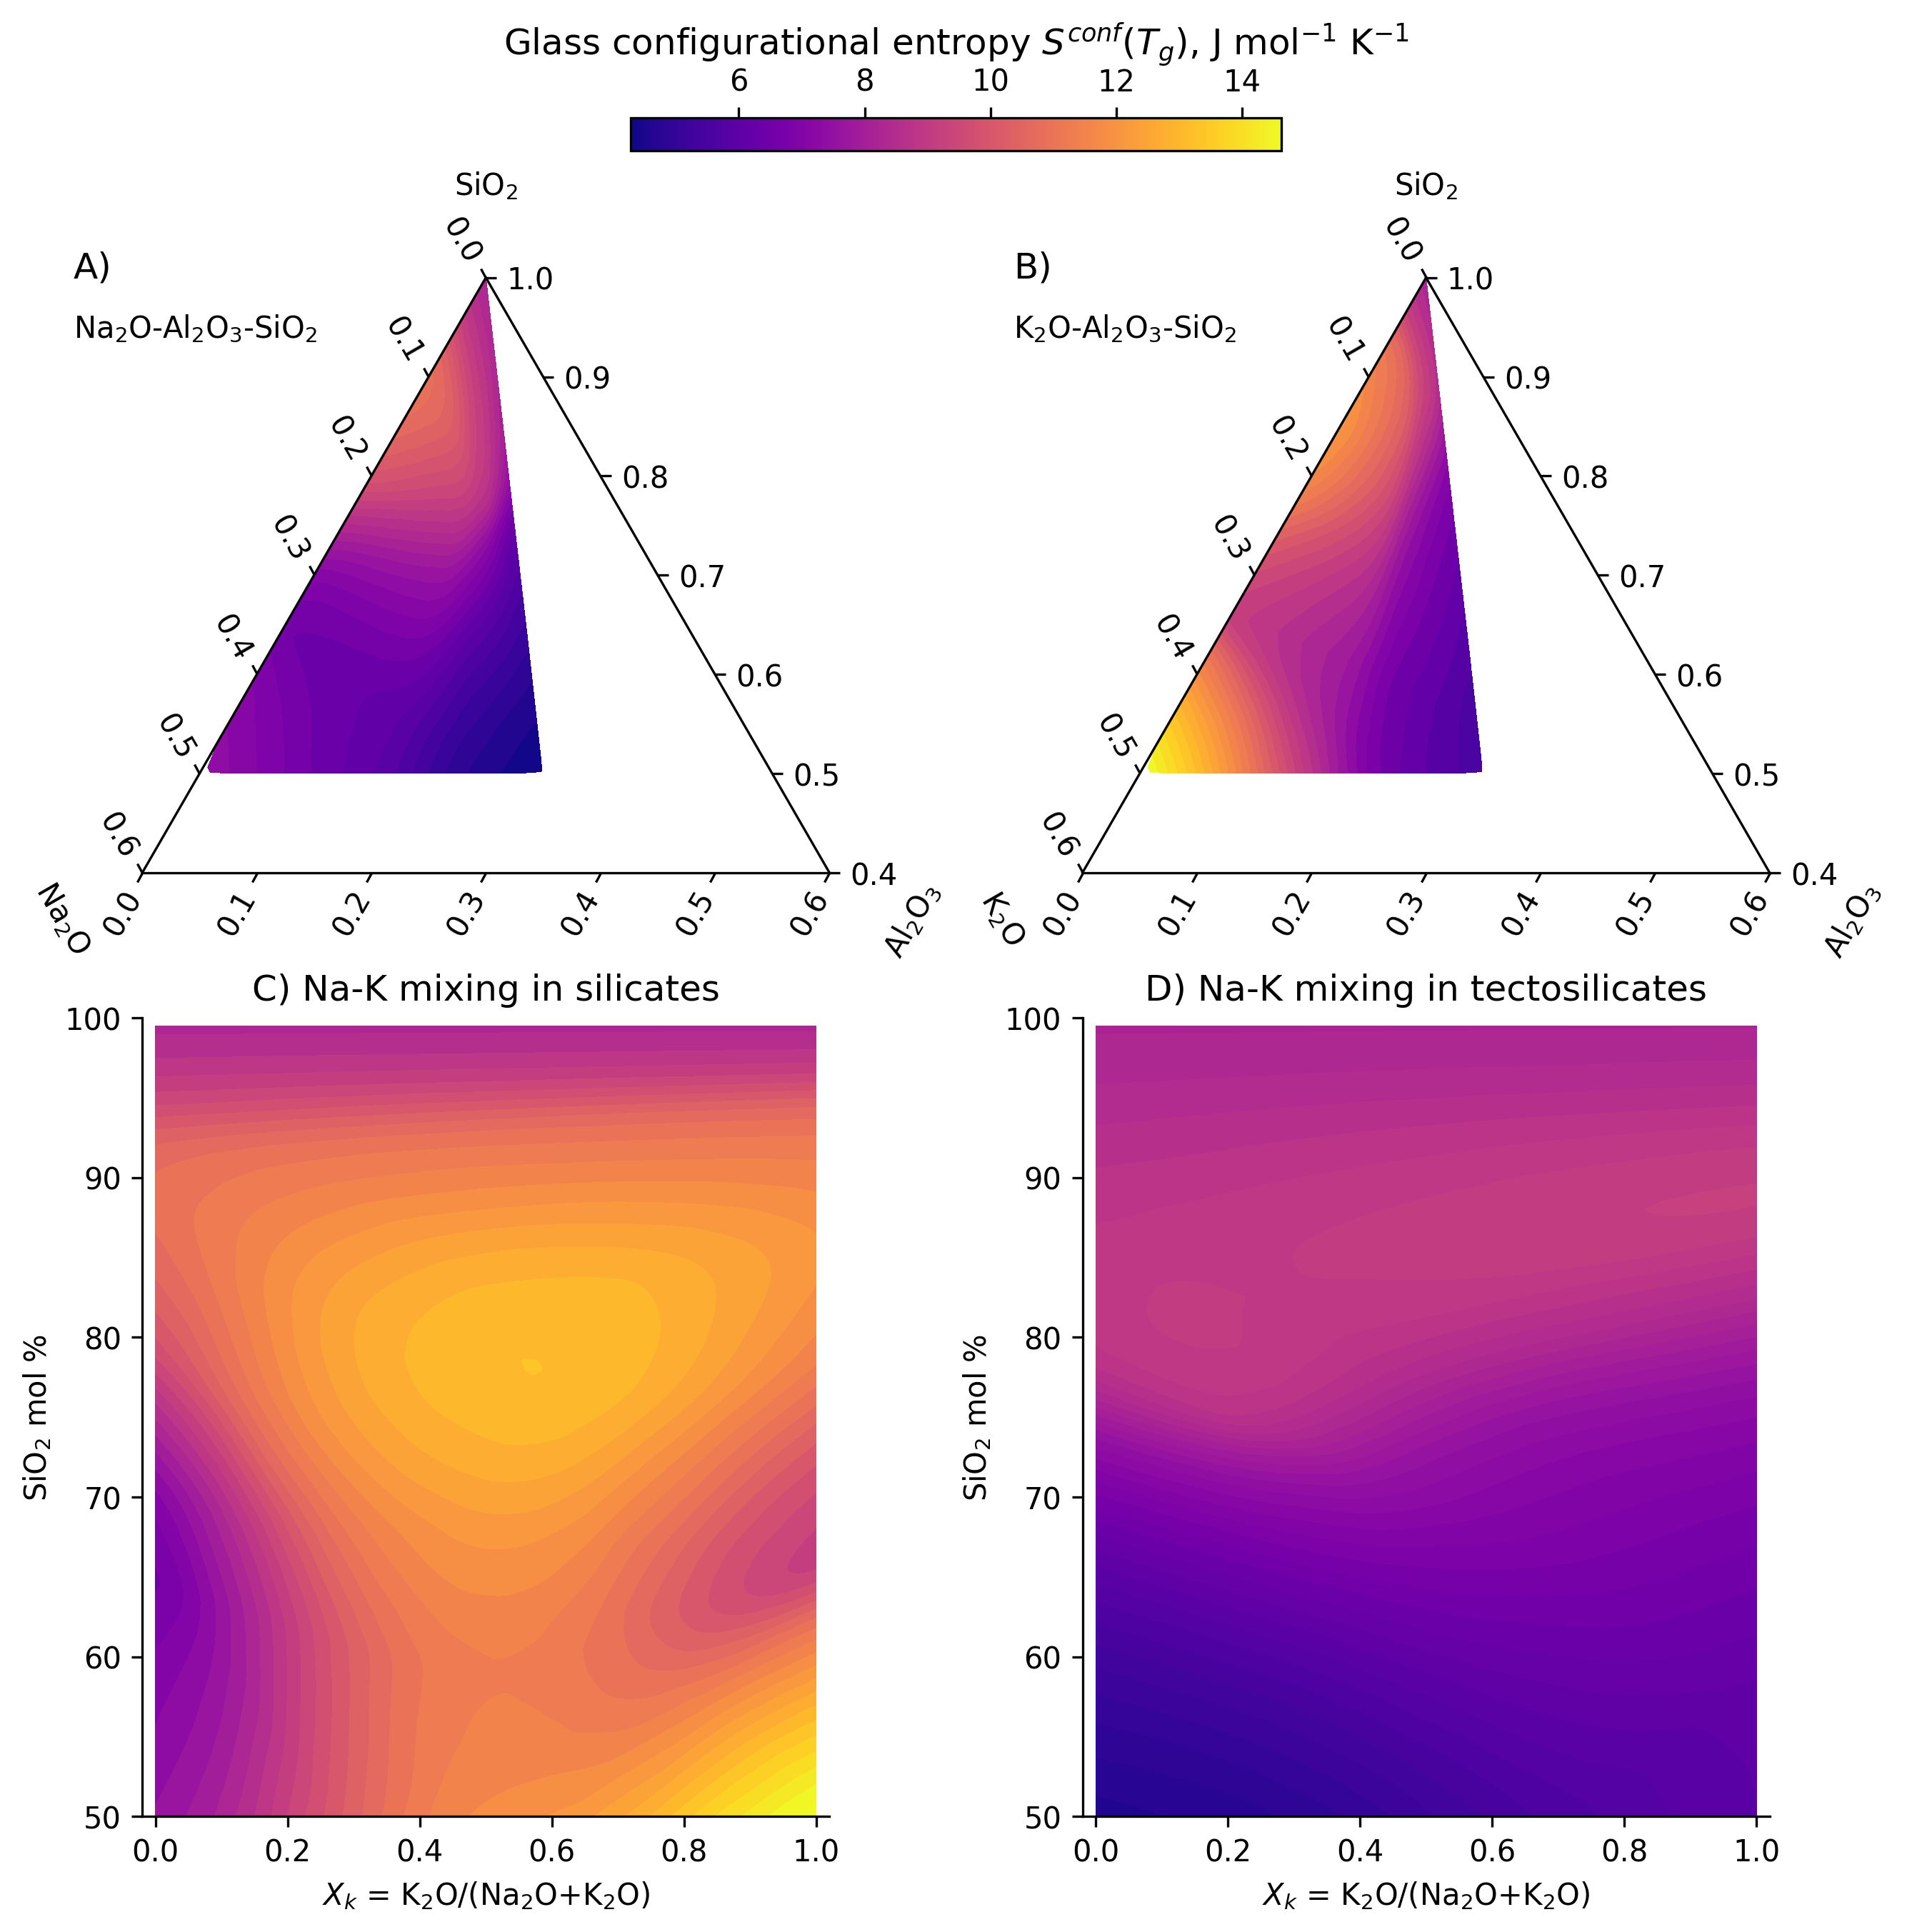

In [15]:
####
#### GENERATING ENTROPY
####

# grabing the entropies along NS/KS
sctg_NAS = neuralmodel.predict("sctg",X_gen_NAS).mean(axis=1)
sctg_KAS = neuralmodel.predict("sctg",X_gen_KAS).mean(axis=1)
sctg_all = neuralmodel.predict("sctg",X_gen_all).mean(axis=1)

# grabing the entropies for the mixtures
sctg_RS_Xk = neuralmodel.predict("sctg",X_gen_RS_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
sctg_R3_Xk = neuralmodel.predict("sctg",X_gen_R3_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
sctg_R1_Xk = neuralmodel.predict("sctg",X_gen_R1_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)

####
#### COLOR CALCULATIONS
####

trig_color_plot = sctg_all # for the colors > same scale 

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(trig_color_plot),
    vmax=np.max(trig_color_plot))

c_m = matplotlib.cm.plasma # choose a colormap
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm) # create a ScalarMappable and initialize a data structure

####
#### FIGURE DECLARATION
####

plt.figure(figsize=(9,9),dpi=300)

####
#### TERNARY PLOT NAS
####

ax = plt.subplot(2,2,1,projection='ternary')

# data are plotted
ax.tricontourf(X_gen_NAS_rec.sio2,X_gen_NAS_rec.na2o,X_gen_NAS_rec.al2o3, 
                sctg_NAS, 
                levels=30, cmap=c_m, norm=norm)

ax.set_tlabel('SiO$_2$')
ax.set_llabel('Na$_2$O')
ax.set_rlabel('Al$_2$O$_3$')

# Using ``ternary_lim``, you can limit the range of ternary axes.
# Be sure about the consistency; the limit values must satisfy:
# tmax + lmin + rmin = tmin + lmax + rmin = tmin + lmin + rmax = ternary_scale
ax.set_ternary_lim(
    0.4, 1.0,  # tmin, tmax
    0.0, 0.6,  # lmin, lmax
    0.0, 0.6,  # rmin, rmax
)

ax.annotate("A)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)
ax.annotate("Na$_2$O-Al$_2$O$_3$-SiO$_2$", xy=(-0.1,0.9), xycoords="axes fraction")

####
#### TERNARY PLOT KAS
####

ax2 = plt.subplot(2,2,2,projection='ternary')

ax2.tricontourf(X_gen_KAS_rec.sio2,X_gen_KAS_rec.k2o,X_gen_KAS_rec.al2o3, 
                sctg_KAS, 
                levels=30, cmap=c_m, norm=norm)

ax2.set_tlabel('SiO$_2$')
ax2.set_llabel('K$_2$O')
ax2.set_rlabel('Al$_2$O$_3$')

# Using ``ternary_lim``, you can limit the range of ternary axes.
# Be sure about the consistency; the limit values must satisfy:
# tmax + lmin + rmin = tmin + lmax + rmin = tmin + lmin + rmax = ternary_scale
ax2.set_ternary_lim(
    0.4, 1.0,  # tmin, tmax
    0.0, 0.6,  # lmin, lmax
    0.0, 0.6,  # rmin, rmax
)

ax2.annotate("B)", xy=(-0.1,1.0), xycoords="axes fraction",fontsize=12)
ax2.annotate("K$_2$O-Al$_2$O$_3$-SiO$_2$", xy=(-0.1,0.9), xycoords="axes fraction")

####
#### XK along near tectosilicate joint
####

ax3= plt.subplot(2,2,3)
tc1 = ax3.tricontourf(X_gen_RS_Xk_rec.loc[:,"xk"], 
                X_gen_RS_Xk_rec.loc[:,"sio2"]*100, 
                sctg_RS_Xk, 
                levels=30, cmap=c_m, norm=norm)

ax3.set_xlim(-0.02,1.02)
ax3.set_ylim(50,100.)

plt.xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
plt.ylabel(r"SiO$_2$ mol %")

# Hide the right and top spines
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

# Title
ax3.set_title("C) Na-K mixing in silicates", loc='center')

####
#### XK along near tectosilicate joint
####
ax4= plt.subplot(2,2,4)
tc1 = plt.tricontourf(X_gen_R1_Xk_rec.loc[:,"xk"], 
                X_gen_R1_Xk_rec.loc[:,"sio2"]*100, 
                sctg_R1_Xk, 
                levels=30, cmap=c_m, norm=norm)
#
#ax4.scatter(X_gen_R1_Xk_rec.loc[:,"xk"],X_gen_R1_Xk_rec.loc[:,"sio2"]*100,s=1,c="k", cmap="RdBu_r")
ax4.set_xlim(-0.02,1.02)
ax4.set_ylim(50,100.)

plt.xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
plt.ylabel(r"SiO$_2$ mol %")

# Hide the right and top spines
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

# Title
ax4.set_title("D) Na-K mixing in tectosilicates", loc='center')

####
#### Layout adjustment
####

# This should be done befor color bar, it's actually tricky...
plt.tight_layout(h_pad=0.1, w_pad=1)

####
#### colorbar
####

cbar_0 = plt.colorbar(mappable=s_m, ax=[ax,ax2],shrink=0.4,location='top',anchor=(0.5,1.0))
cbar_0.set_label(r"Glass configurational entropy $S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$", fontsize=12)

plt.savefig("./figures/Figure3_entromaps.png",bbox_inches="tight")

### Notebook figure : comparison of model predictions and values calculated from viscosity data by previous studies.

Configurational entropy values are available for glasses between the albite-orthoclase and Na-K trisilicate compositions. We compare those values to model predictions below.

We do not expect them to be identical as the model may capture better true variations in glass configurational entropy compared to single-composition adjustments performed in the cited studies. (see text for references)

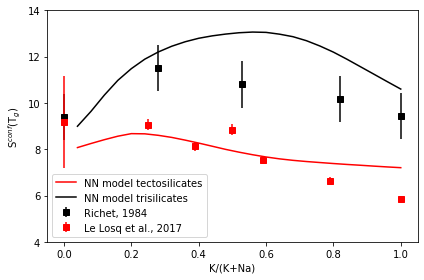

In [16]:
plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$), J mol$^{-1}$ K$^{-1}$")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.28,0.53,0.82,1.0]),np.array([32.91,40.31,37.81,35.59,32.99])/7.0*2.0,
    yerr = 1.0, fmt="ks",
    label="Richet, 1984")

## endmember silicate
na2o = np.arange(0.,0.125,0.005)
k2o = 0.125-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.ones(len(na2o))*0.125

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),neuralmodel.predict("sctg",X_visu_).mean(axis=1),'r-',label="NN model tectosilicates")

## endmember silicate
na2o = np.arange(0.,0.25,0.01)
k2o = 0.25-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.zeros(len(na2o))

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),neuralmodel.predict("sctg",X_visu_).mean(axis=1),'k-',label="NN model trisilicates")


plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.25,0.39,0.50,0.59,0.79,1.00]),
             np.array([9.17,9.06,8.12,8.84,7.54,6.63,5.83]),
    yerr = np.array([2.,0.23,0.20,0.23,0.18,0.15,0.11]), fmt="s", color="r",
    label="Le Losq et al., 2017")
plt.legend()
plt.tight_layout()

# Figures 4 and 5 : correlations between melt/glass parameters and latent variables

To do that, we generate 10,000 random compositions, make predictions of several parameters, and look at the relationship between them.

In [17]:
#
# number of samples
#

nb_samples = 10000

#
# Generating the random compositions in the delimited ternary diagram
#

sio2_gen = np.random.random_sample(nb_samples)*0.5 + 0.5

reminder = 1.0 - sio2_gen

R_MAl = np.random.random_sample(nb_samples)*(1.0-0.4) + 0.4 # ratio of alkalis to Al

R_XK = np.random.random_sample(nb_samples) # ratio K/(K+Na)

al2o3_gen = (1.0 - R_MAl)*reminder

reminder = 1 - sio2_gen - al2o3_gen

na2o_gen = reminder*(1.0-R_XK)
k2o_gen = 1 - sio2_gen - al2o3_gen - na2o_gen

X_gen = pd.DataFrame()
X_gen["sio2"] = sio2_gen
X_gen["al2o3"] = al2o3_gen
X_gen["na2o"] = na2o_gen
X_gen["k2o"] = k2o_gen
M_glass = sio2_gen*60.08 + al2o3_gen*101.96 + na2o_gen*61.9789 + k2o_gen*94.2
X_rec = X_gen.copy() # this is to have a copy (non-torch, pandas)
X_gen = torch.Tensor(X_gen.values).to(device)

#
# Making predictions
#

Raman_gen = neuralmodel.predict("raman_pred",X_gen).mean(axis=2)

Rr_gen = np.trapz(Raman_gen[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(Raman_gen[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

# all parameters

samples = np.concatenate((neuralmodel.predict("ae",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("a_am",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("a_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("be",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("sctg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("be",X_gen).mean(axis=1).reshape(-1,1)/neuralmodel.predict("sctg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("b_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("b_tvf",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("to_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("c_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("c_tvf",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("fragility",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("density",X_gen).mean(axis=1).reshape(-1,1),
                          M_glass.reshape(-1,1)/neuralmodel.predict("density",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("tg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("sellmeier",X_gen,lbd=589.0*np.ones((len(X_gen),1))).mean(axis=1).reshape(-1,1),
                          Rr_gen.reshape(-1,1)
                         ),axis=1)

labels = [r"$A_e$", r"$A_{AM}$", r"$A_{CG}$", 
          r"$B_e$", r"$S^{conf}(T_g)$", r"$B_e/S^{conf}(T_g)$", 
          r"$B_{CG}$", r"$B_{TVF}$", r"$T_o$", r"$C_{CG}$", r"$C_{TVF}$", 
          r"m", r"d", r"$V_m$",r"$T_g$",r"$n_{589}$", r"R$_{Raman}$"]

# subset of highly correlated parameters

samples_2 = np.concatenate((neuralmodel.predict("sellmeier",X_gen,lbd=589.0*np.ones((len(X_gen),1))).mean(axis=1).reshape(-1,1),
                            neuralmodel.predict("be",X_gen).mean(axis=1).reshape(-1,1)/neuralmodel.predict("sctg",X_gen).mean(axis=1).reshape(-1,1),
                            neuralmodel.predict("b_cg",X_gen).mean(axis=1).reshape(-1,1)/neuralmodel.predict("c_cg",X_gen).mean(axis=1).reshape(-1,1),
                            neuralmodel.predict("tg",X_gen).mean(axis=1).reshape(-1,1),
                            Rr_gen.reshape(-1,1)
                           ),axis=1)

labels_2 = [r"$n_{589}$", r"$B_e/S^{conf}(T_g)$", r"$B_{CG}$", r"$T_g$", r"R$_{Raman}$"]

### Notebook figure : general correlation plot of all predicted variables

<Figure size 1080x1080 with 0 Axes>

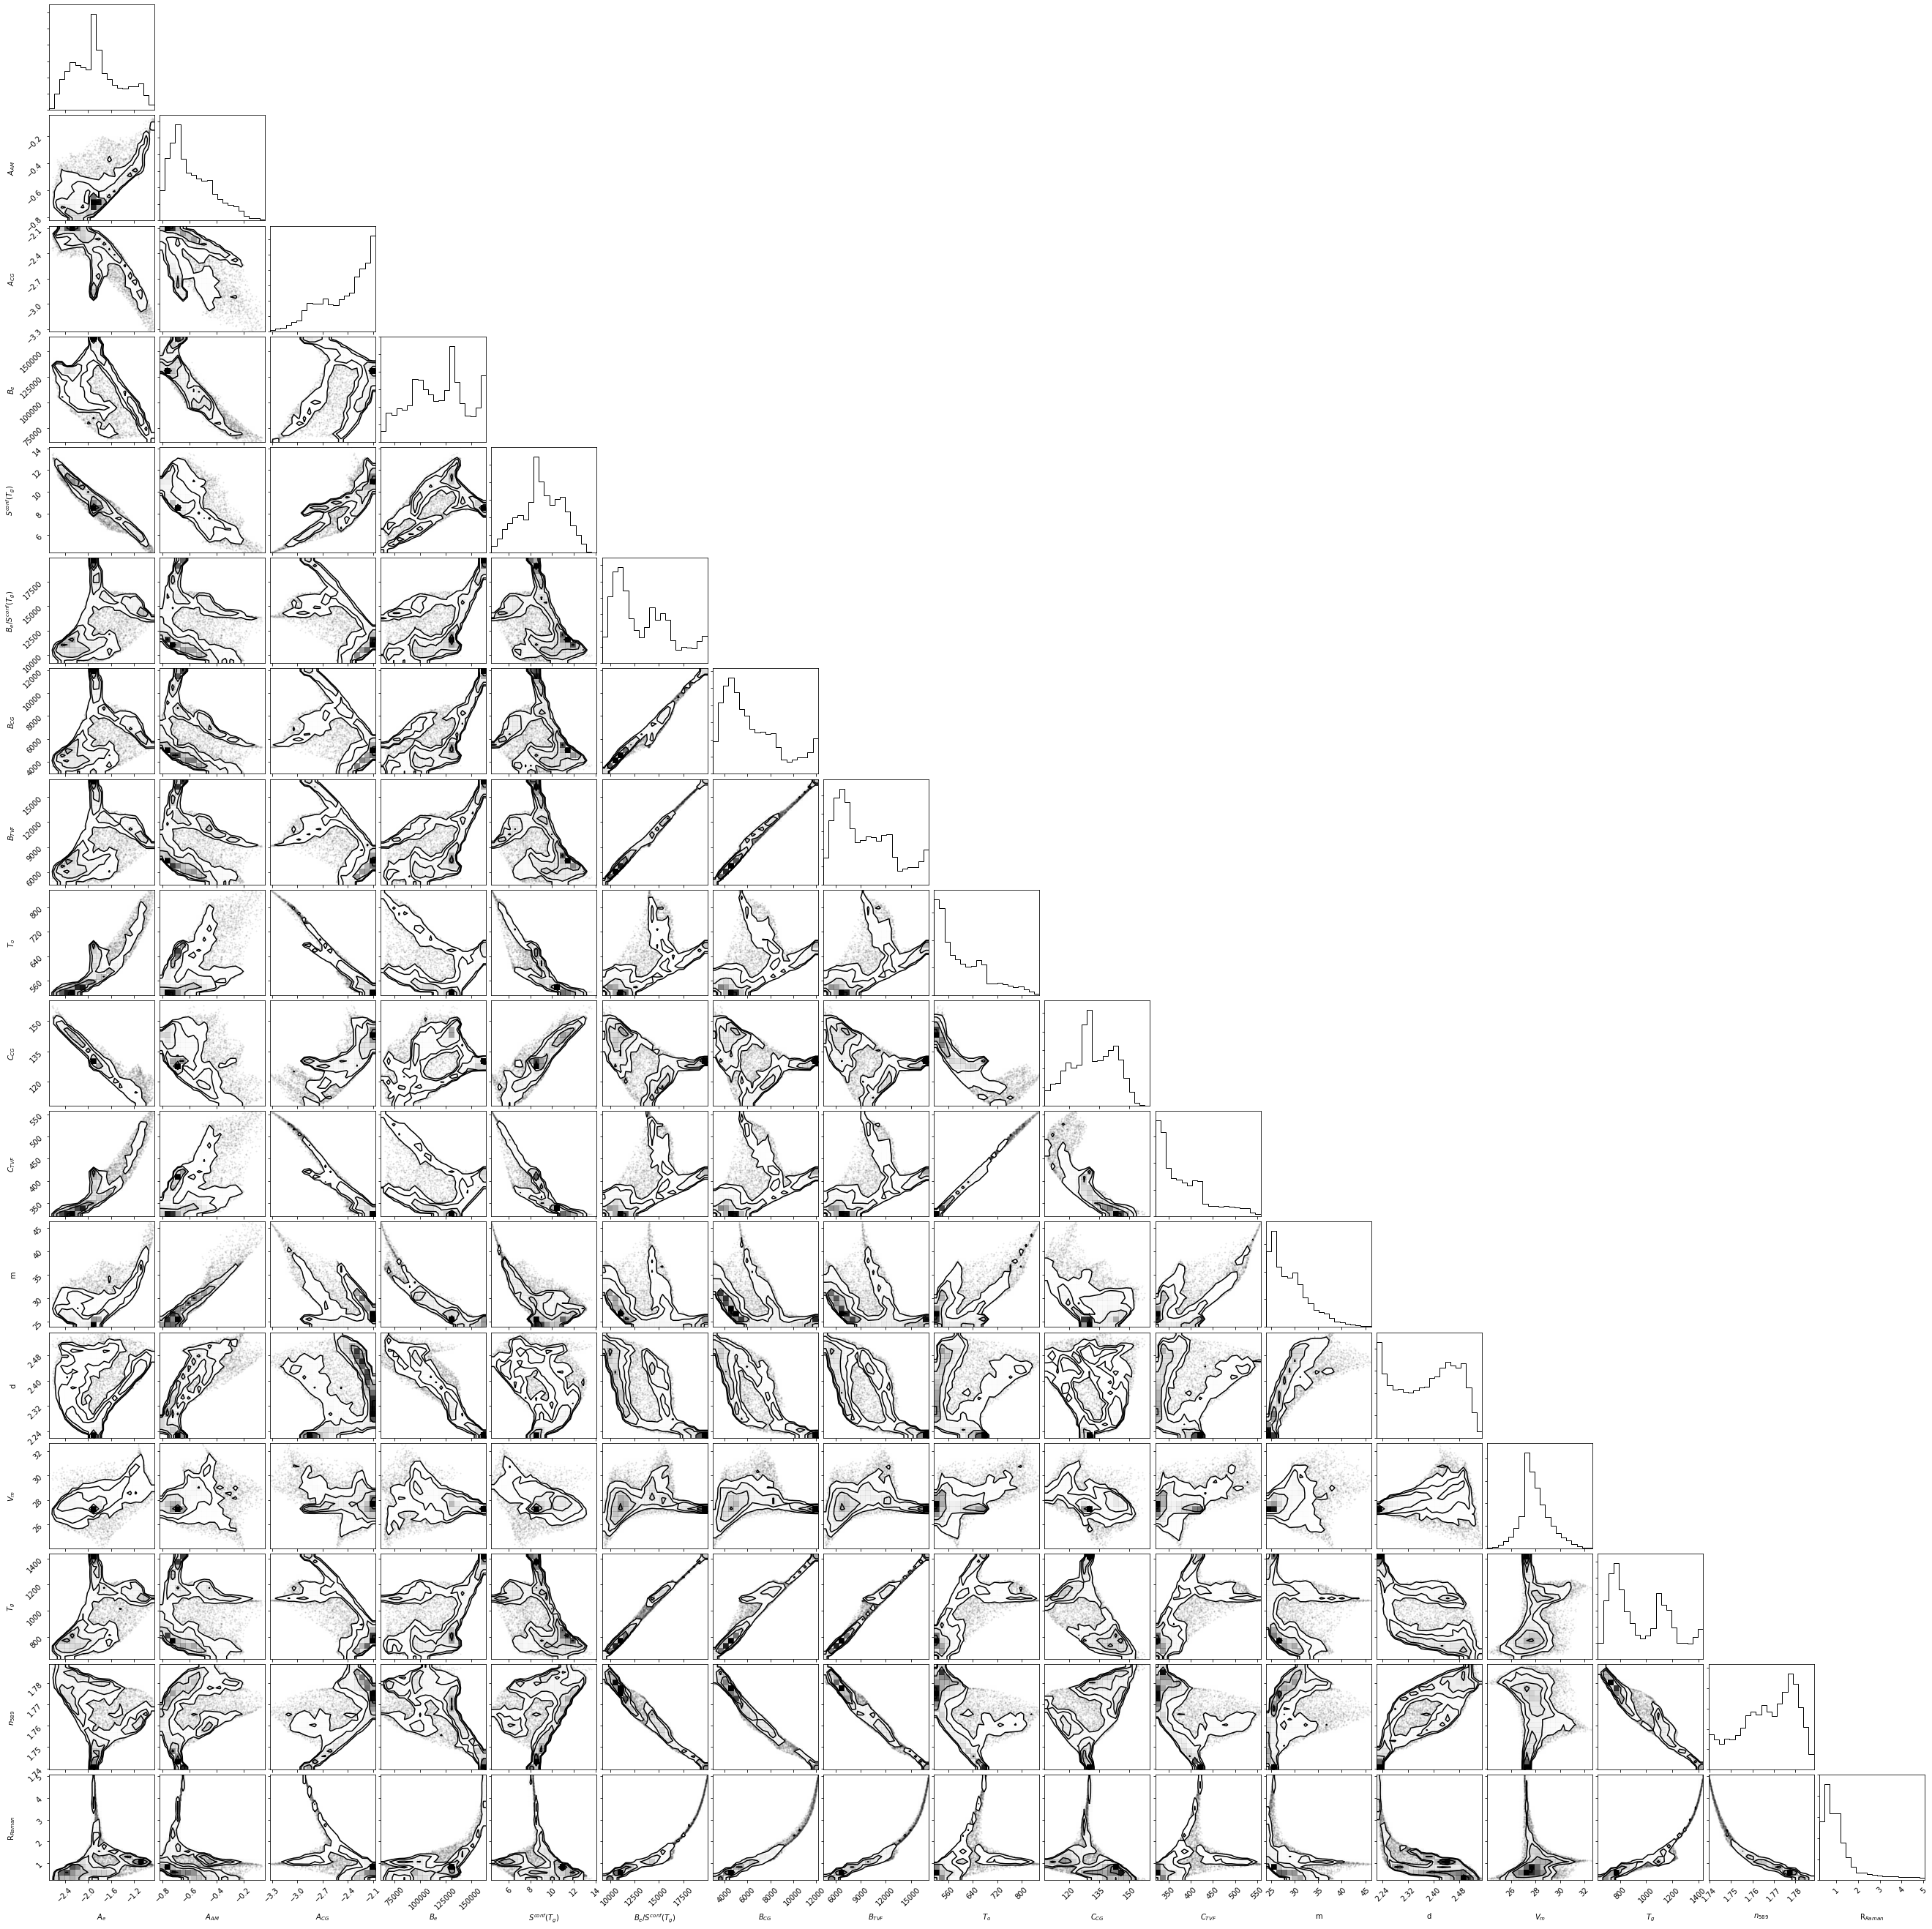

In [18]:
plt.figure(figsize=(15,15))
corner.corner(samples, labels=labels)

plt.savefig("./figures/Correlations.pdf")


Below we test Spearman correlations between variables, allows to see unlinear correlated features.

In [19]:
df_samples = pd.DataFrame(data= samples, columns=labels)
sp_corr = df_samples.corr(method="spearman")
# 'RdBu_r' & 'BrBG' are other good diverging colormaps
sp_corr.style.background_gradient(cmap='coolwarm')


### Notebook figure : specific correlation plots of highly correlated variables

We only look at highly correlated variables.

In [20]:
df_samples_2 = pd.DataFrame(data= samples_2, columns=labels_2)
sp_corr_2 = df_samples_2.corr(method="spearman")
# 'RdBu_r' & 'BrBG' are other good diverging colormaps
sp_corr_2.style.background_gradient(cmap='coolwarm')


<Figure size 1200x800 with 0 Axes>

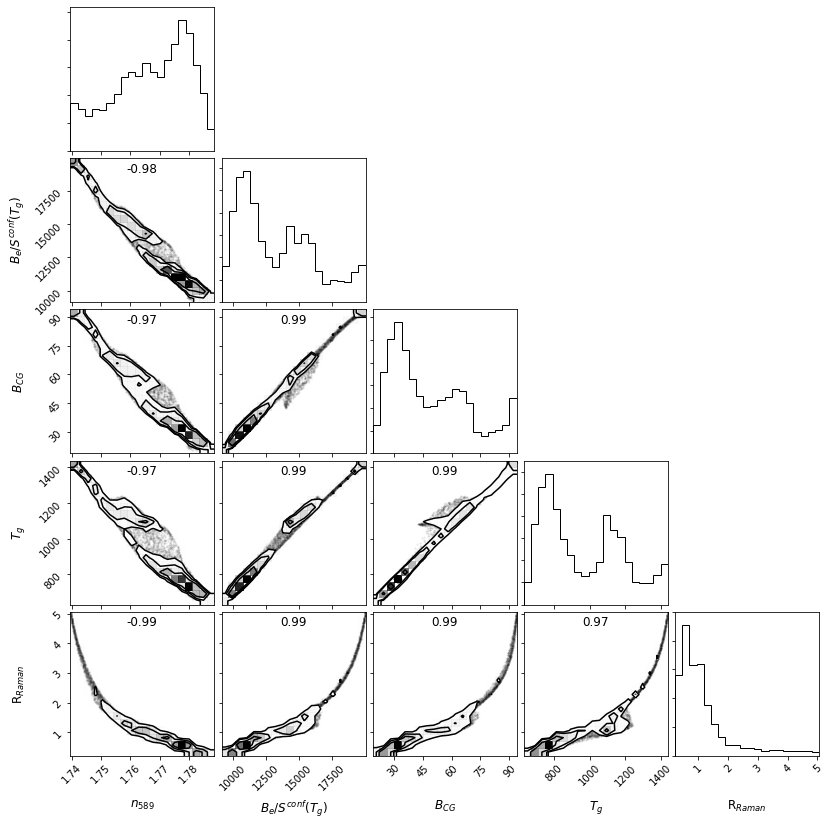

In [21]:
plt.figure(dpi=200)
label_kwargs = {"fontsize" : 12}

fig = corner.corner(samples_2, labels=labels_2, label_kwargs=label_kwargs)


# how many variables ?
ndim = samples_2.shape[1]

# Extract the axes
axes = np.array(fig.axes).reshape((ndim, ndim))

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        # add annotation with spearman correlation coefficient
        ax = axes[yi, xi]
        #ax.annotate("{}, {}".format(yi,xi),xy=(0.5,0.9),xycoords="axes fraction", ha='center')
        ax.annotate("{:.2f}".format(sp_corr_2.values[yi,xi]),xy=(0.5,0.9),xycoords="axes fraction", ha='center',fontsize=12)

From the above figure, we notice that several separated variables are actually well linearly correlated, like glass refractive index, glass transition temperature, $B_{CG}$ and  $B_e/S^{conf}(T_g)$.

It thus seem that the Free volume theory and the Adam and Gibbs theory succeed to capture the underlying reality behind glass transition temperature, glass structure, and hindrance of the atomic mobility.

However, R$_{Raman}$ is not linearly correlated to all those variables, suggesting that Raman spectroscpuy misses (is blind to) something there.


### Figure 4

This figure the ground links between measurable quantities (glass refractive index, Tg) and thermodynamic/dynamic latent variables.

In [22]:
def CLR(input_array):
    """Transform chemical composition in colors
    
    Inputs
    ------
    input_array: n*4 array
        4 chemical inputs with sio2, al2o3, k2o and na2o in 4 columns, n samples in rows
        
    Returns
    -------
    out: n*3 array
        RGB colors
    """
    XXX = input_array.copy()
    XXX[:,2] = XXX[:,2]+XXX[:,3] # adding alkalis
    out = np.delete(XXX,3,1) # remove 4th row
    # min max scaling to have colors in the full RGB scale
    out[:,0] = (out[:,0]-out[:,0].min())/(out[:,0].max()-out[:,0].min())
    out[:,1] = (out[:,1]-out[:,1].min())/(out[:,1].max()-out[:,1].min())
    out[:,2] = (out[:,2]-out[:,2].min())/(out[:,2].max()-out[:,2].min())
    return out

X_rec_forcart = X_rec
X_rec_forcart["alkalis"] = X_rec.na2o+X_rec.k2o
cart_rec = bary2cart(X_rec_forcart.loc[:,["alkalis","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))

['$n_{589}$', '$B_e/S^{conf}(T_g)$', '$B_{CG}$', '$T_g$', 'R$_{Raman}$']


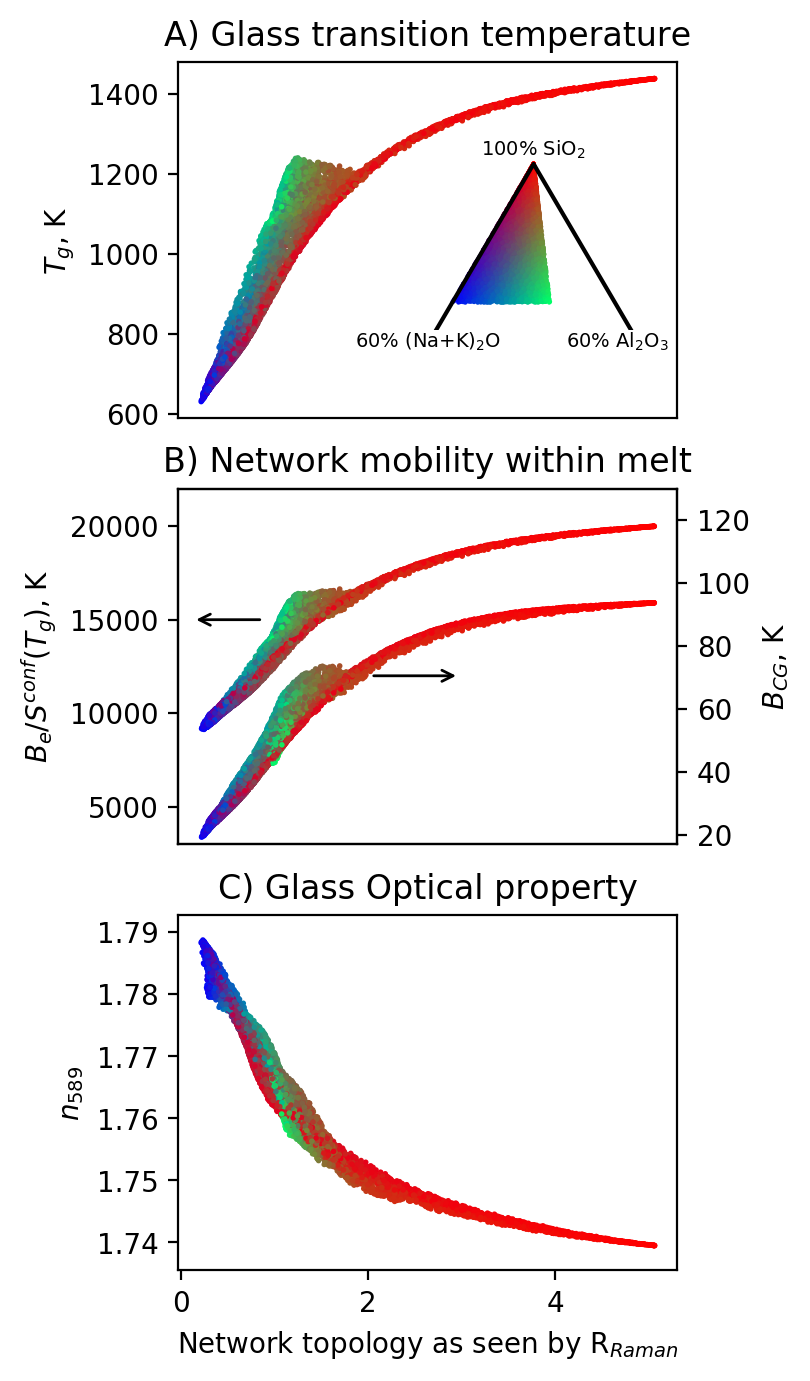

In [23]:
plt.figure(figsize=(3.22,8),dpi=200)
fig4_a = plt.subplot(3,1,1)
fig4_b = plt.subplot(3,1,2)
fig4_c = fig4_b.twinx()
fig4_d = plt.subplot(3,1,3)

####
#### TERNARY PLOT
####

# Create inset of width 1.3 inches and height 0.9 inches
# at the default upper right location
axins = inset_axes(fig4_a, width=1.3, height=0.9,loc='right')

axins.scatter(cart_rec[:,0],cart_rec[:,1],s=0.5,c=CLR(X_gen.detach().numpy()))
axins.plot([0,1,2,0],[0,1,0,0],"k-")

axins.set_xlim(0.2,1.8)
axins.set_ylim(0.4,1.05)

axins.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center",fontsize=7)
axins.annotate(r"60% Al$_2$O$_3$", xy = (1.2,0.4),xycoords="data",ha="left",va="top",fontsize=7)
axins.annotate(r"60% (Na+K)$_2$O", xy = (0.8,0.4),xycoords="data",ha="right",va="top",fontsize=7)

axins.axis("off")

####
#### DATA PLOT
####

fig4_a.scatter(samples_2[:,4],samples_2[:,3],s=1,c=CLR(X_gen.detach().numpy()))
fig4_b.scatter(samples_2[:,4],samples_2[:,1],s=1,c=CLR(X_gen.detach().numpy()))
fig4_c.scatter(samples_2[:,4],samples_2[:,2],s=1,c=CLR(X_gen.detach().numpy()))
fig4_d.scatter(samples_2[:,4],samples_2[:,0],s=1,c=CLR(X_gen.detach().numpy()))

fig4_a.set_ylabel("$T_{g}$, K")
fig4_c.set_ylabel("$B_{CG}$, K")
fig4_b.set_ylabel("$B_e/S^{conf}(T_g)$, K")
fig4_d.set_ylabel("$n_{589}$")

fig4_c.set_ylim(17,130)
fig4_b.set_ylim(3000,22000)

fig4_d.set_xlabel('Network topology as seen by R$_{Raman}$')

fig4_a.set_xticks([])
fig4_b.set_xticks([])

fig4_a.set_title("A) Glass transition temperature")
fig4_b.set_title("B) Network mobility within melt")
fig4_d.set_title("C) Glass Optical property")
#fig4_a.annotate("A) Glass transition",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
#fig4_b.annotate("B) Network mobility",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
#fig4_d.annotate("C) Optical property",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

#
# arrows in plot B
#
fig4_b.annotate("", xy=(3.0, 12000), xytext=(2.0, 12000), arrowprops=dict(arrowstyle="->"))
fig4_b.annotate("", xy=(0.1, 15000), xytext=(0.9, 15000), arrowprops=dict(arrowstyle="->"))

print(labels_2)

plt.savefig("./figures/Figure4.png",bbox_inches="tight")

# Figure 5 : absence of direct link between network topology and parameters that embed entropic/non-topologic information.

Entropy is not only due to the network topology (the geometry of the Si-Al-O polyhedral network) but is also affected by mixing effects, e.g. between Al and Si as well as Na and K.

Therefore, any parameter that embeds entropic information is expected to vary in a complex way with $R_{Raman}$. 

This is what we observed here. Melt fragility (proportional to the ratio of entropy to heat capacity), configurational glass entropy, or $C_{CG}$ (critical free volume that should relate to the intrisic entropy) all vary in a complex way contary to other parameters that nearly directly depends on network topology (see last figure).

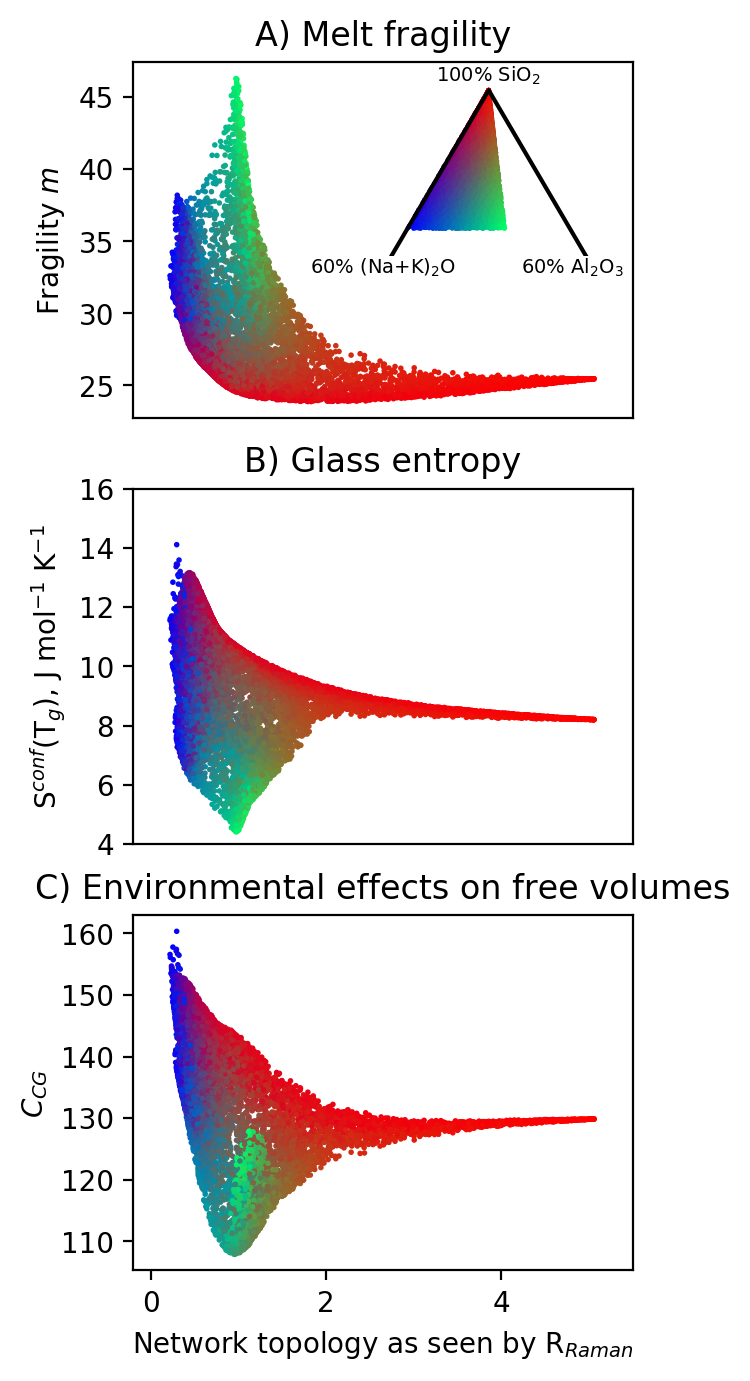

In [24]:
#
# Plot template
#
plt.figure(figsize=(3.22,8),dpi=200)
fig5_a = plt.subplot(3,1,1)
fig5_b = plt.subplot(3,1,2)
fig5_c = plt.subplot(3,1,3)

#
# Plot ternary diagram
#
# Create inset of width 1.3 inches and height 0.9 inches
# at the default upper right location
axins = inset_axes(fig5_a, width=1.3, height=0.9,loc='upper right')

####
#### TERNARY PLOT
####

axins.scatter(cart_rec[:,0],cart_rec[:,1],s=0.5,c=CLR(X_gen.detach().numpy()))
axins.plot([0,1,2,0],[0,1,0,0],"k-")

axins.set_xlim(0.2,1.8)
axins.set_ylim(0.4,1.05)

axins.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center",fontsize=7)
axins.annotate(r"60% Al$_2$O$_3$", xy = (1.2,0.4),xycoords="data",ha="left",va="top",fontsize=7)
axins.annotate(r"60% (Na+K)$_2$O", xy = (0.8,0.4),xycoords="data",ha="right",va="top",fontsize=7)

axins.axis("off")

#
# Plot values
#
fig5_a.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("fragility",X_gen).mean(axis=1), s=1,c=CLR(X_gen.detach().numpy()))
fig5_b.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("sctg",X_gen).mean(axis=1), s=1,c=CLR(X_gen.detach().numpy()))
fig5_c.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("c_cg",X_gen).mean(axis=1), s=1,c=CLR(X_gen.detach().numpy()))

#
# Axes limites
#
fig5_a.set_xlim(-0.2,5.5)
fig5_b.set_xlim(-0.2,5.5)
fig5_c.set_xlim(-0.2,5.5)


fig5_b.set_ylim(4,16)

#
# axes labels
#
fig5_a.set_ylabel(r"Fragility $m$")
fig5_b.set_ylabel(r"S$^{conf}$(T$_{g}$), J mol$^{-1}$ K$^{-1}$")
fig5_c.set_ylabel(r"$C_{CG}$")

fig5_c.set_xlabel('Network topology as seen by R$_{Raman}$')

fig5_a.set_xticks([])
fig5_b.set_xticks([])

fig5_a.set_title("A) Melt fragility")
fig5_b.set_title("B) Glass entropy")
fig5_c.set_title("C) Environmental effects on free volumes")
plt.savefig("./figures/Figure5.png",bbox_inches="tight")

### Supplementary notebook figure : correlation between B$_{TVF}$ and B$_{CG}$, as well as C$_{TVF}$ and T$_{0}$.

Basically this tells us that the CG equation is an improvement of the TVF equation ? To and C_TVF are related to the Kauzman temperature... The Kauzman temperature is a "fictive" temperature at which a cooled liquid would present a lower entropy than a crystal. This situation is not possible and would lead to a paradox, called the Kauzman paradox. There is theories stating that glass transition actually is meant to occur to avoid this catastrophique entropic crisis...

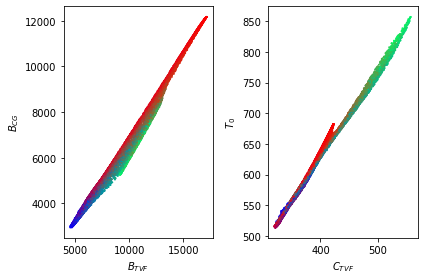

In [25]:
plt.subplot(1,2,1)
plt.scatter(neuralmodel.predict("b_tvf",X_gen).mean(axis=1),              
            neuralmodel.predict("b_cg",X_gen).mean(axis=1),
            s=1,c=CLR(X_gen.detach().numpy()))
plt.xlabel("$B_{TVF}$")
plt.ylabel("$B_{CG}$")

plt.subplot(1,2,2)
plt.scatter(neuralmodel.predict("c_tvf",X_gen).mean(axis=1),              
            neuralmodel.predict("to_cg",X_gen).mean(axis=1),
            s=1,c=CLR(X_gen.detach().numpy()))
plt.xlabel("$C_{TVF}$")
plt.ylabel("$T_0$")
plt.tight_layout()

# Supplementary Figure: Comparison between known values and predictions for other parameters (Tg, entropy...)

Tg test RMSE: 16.0
ScTg test RMSE: 0.8
density test RMSE: 0.009
Refractive index test RMSE: 0.0047


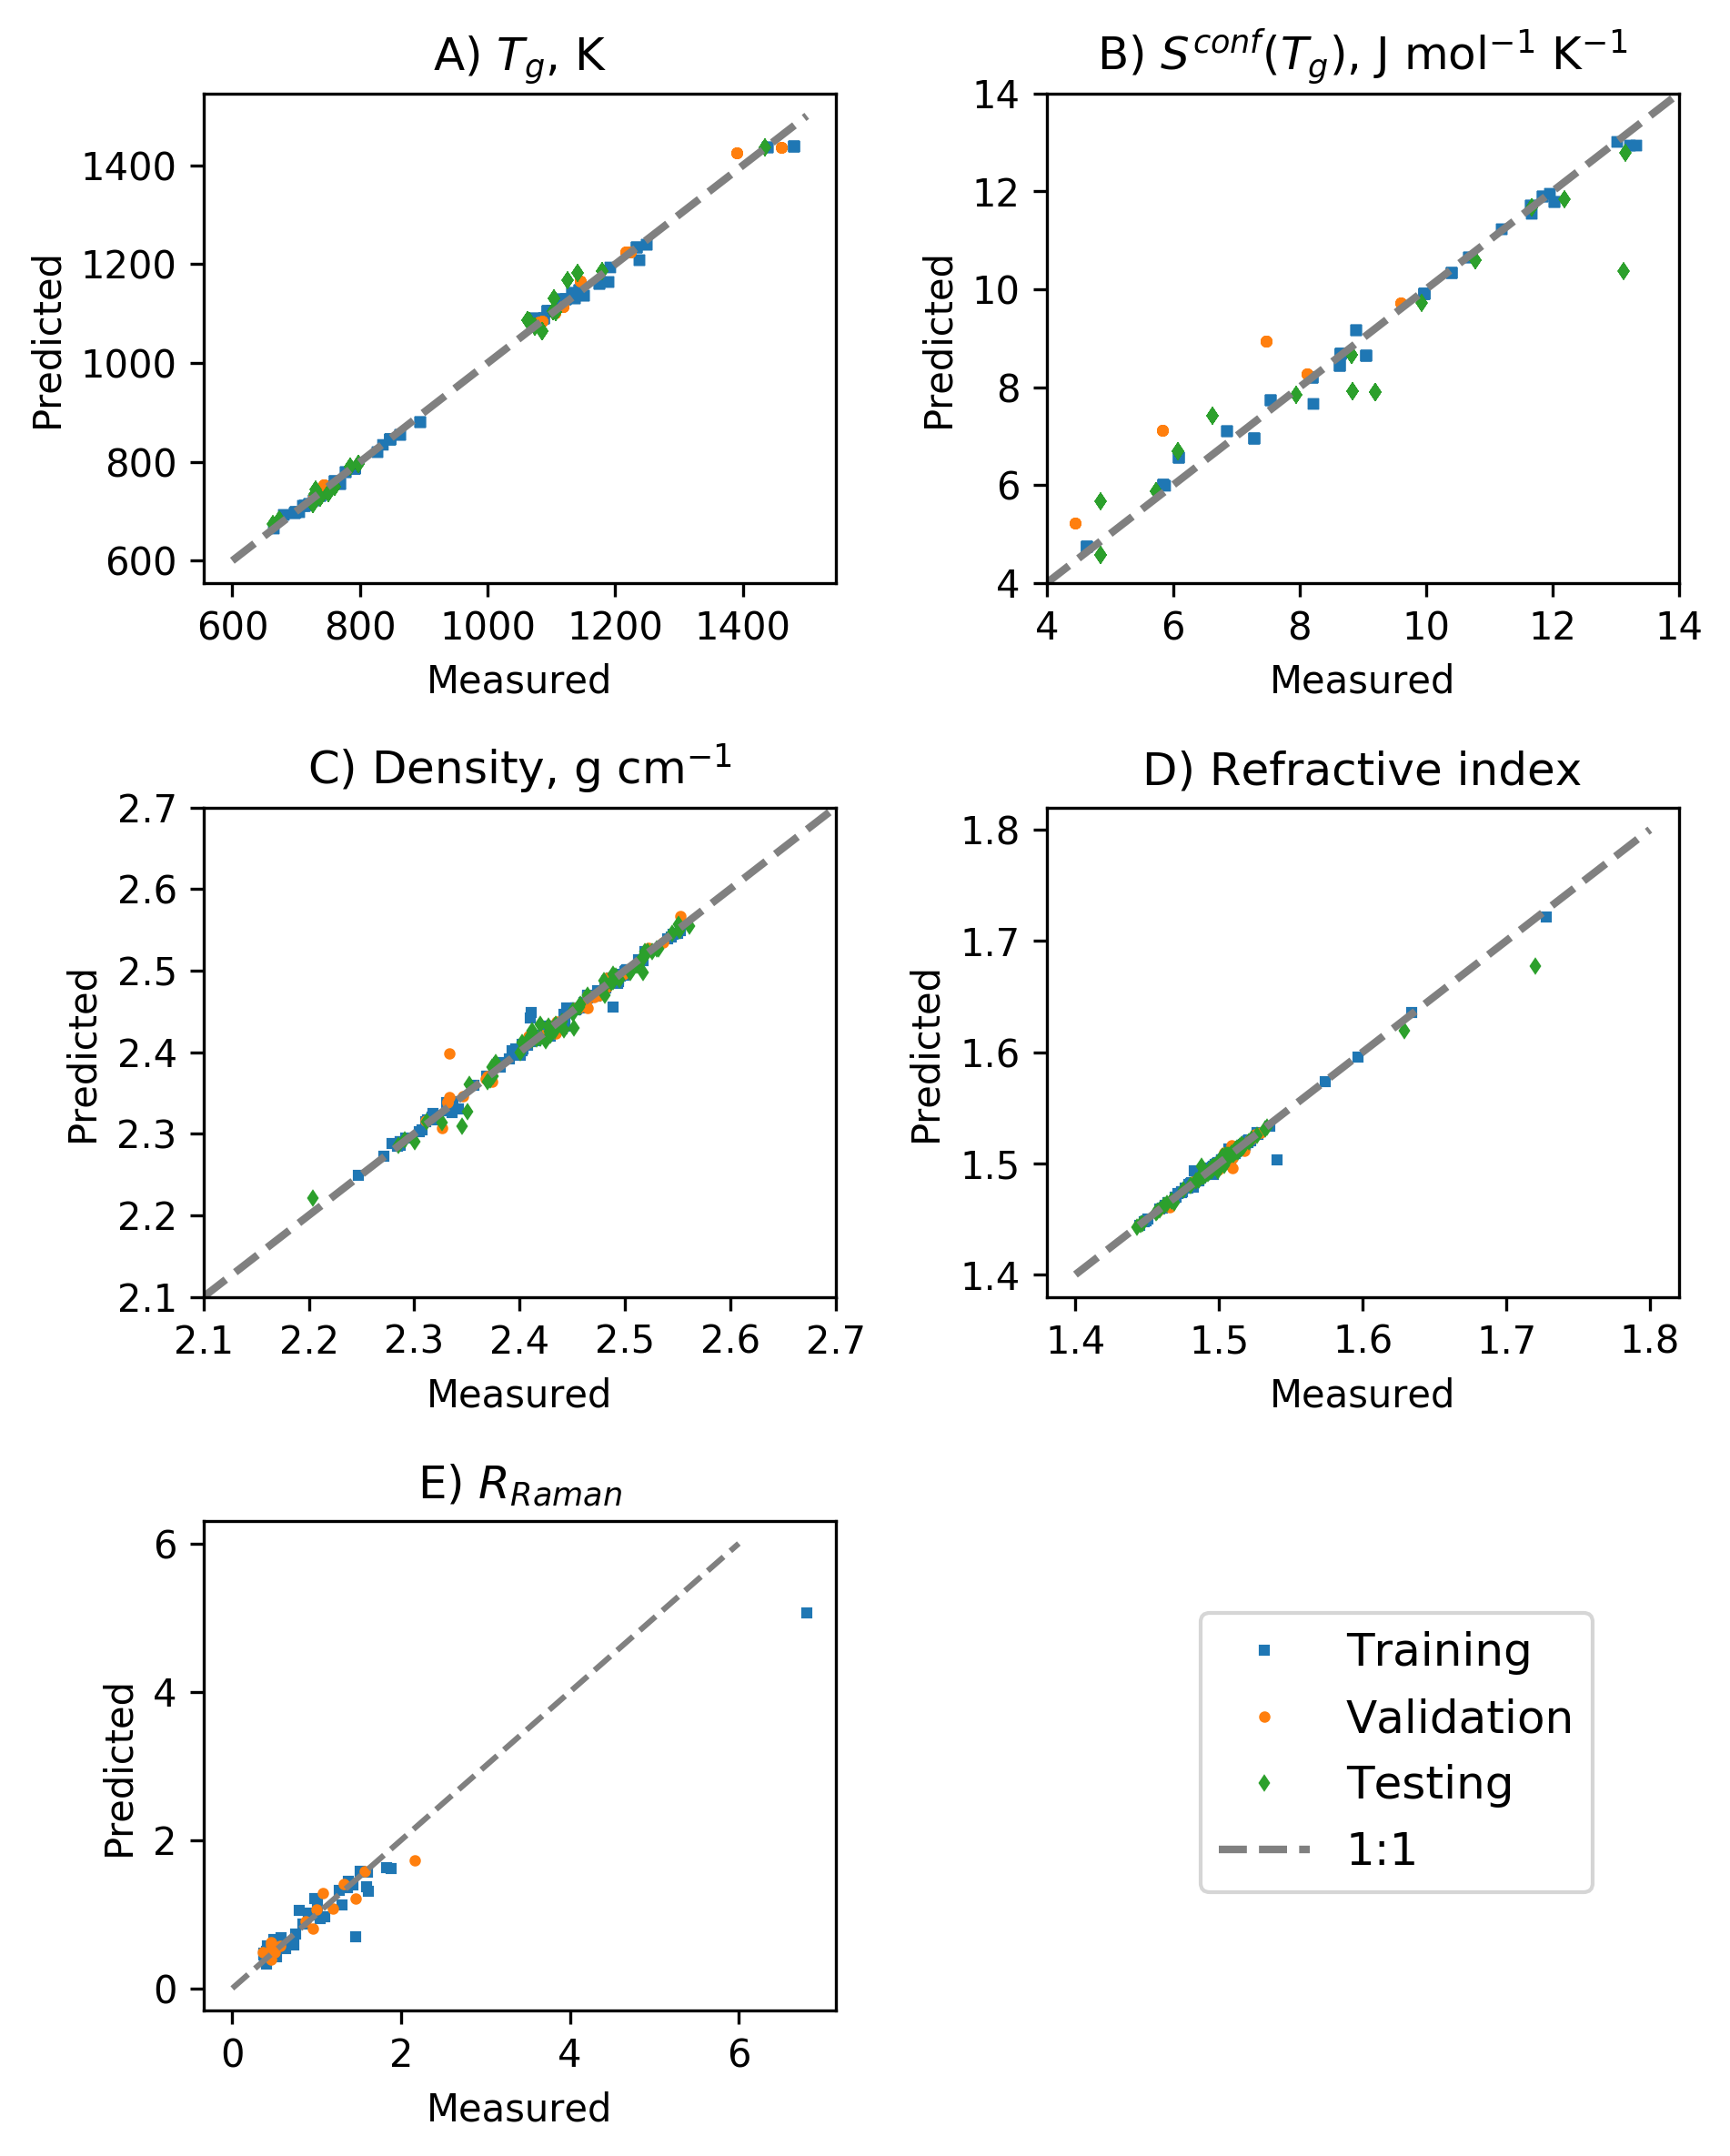

In [26]:
plt.figure(figsize=(6.44,8),dpi=300)

#
# Glass transition temperature
#
tx1 = plt.subplot(3,2,1)
tx1.plot(ds.y_tg_train.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_train).mean(axis=1),
         "s",linestyle="none",color="C0",markersize=2,label="Train")
tx1.plot(ds.y_tg_valid.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Valid")
tx1.plot(ds.y_tg_test.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Test")
RMSE_test_Tg = np.sqrt(mean_squared_error(ds.y_tg_test.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_test).mean(axis=1))) 
print("Tg test RMSE: {0:.1f}".format(RMSE_test_Tg))

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"A) $T_g$, K")

plt.plot([600,1500],[600,1500],"--",color="grey",linewidth=2,label="1:1")

#plt.legend(loc="upper left")

#
# Configurational entropy
#

tx2 = plt.subplot(3,2,2)
tx2.plot(ds.y_entro_train.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Train")
tx2.plot(ds.y_entro_valid.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Valid")
tx2.plot(ds.y_entro_test.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Test")
RMSE_test_ScTg = np.sqrt(mean_squared_error(ds.y_entro_test.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_test).mean(axis=1))) 
print("ScTg test RMSE: {0:.1f}".format(RMSE_test_ScTg))

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"B) $S^{conf}(T_g)$, J mol$^{-1}$ K$^{-1}$")
plt.xlim(4,14)
plt.ylim(4,14)
plt.plot([4,14],[4,14],"--",color="grey",linewidth=2,label="1:1")

#
# Density
#

tx3=plt.subplot(3,2,3)
tx3.plot(ds.y_density_train.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Train")
tx3.plot(ds.y_density_valid.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Valid")
tx3.plot(ds.y_density_test.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Test")
RMSE_test_d = np.sqrt(mean_squared_error(ds.y_density_test.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_test).mean(axis=1))) 
print("density test RMSE: {0:.3f}".format(RMSE_test_d))


plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"C) Density, g cm$^{-1}$")

plt.plot([2.1,2.7],[2.1,2.7],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(2.1,2.7)
plt.ylim(2.1,2.7)
plt.xticks([2.1,2.2,2.3,2.4,2.5,2.6,2.7])
plt.yticks([2.1,2.2,2.3,2.4,2.5,2.6,2.7])

#
# Refractive index
#

tx4 = plt.subplot(3,2,4)

tx4.plot(ds.y_ri_train.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_train, lbd=ds.lbd_ri_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Training")
tx4.plot(ds.y_ri_valid.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_valid, lbd=ds.lbd_ri_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Validation")
tx4.plot(ds.y_ri_test.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_test, lbd=ds.lbd_ri_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Testing")
RMSE_test_ri = np.sqrt(mean_squared_error(ds.y_ri_test.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_test, lbd=ds.lbd_ri_test).mean(axis=1))) 
print("Refractive index test RMSE: {0:.4f}".format(RMSE_test_ri))

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"D) Refractive index")

plt.plot([1.4,1.8],[1.4,1.8],"--",color="grey",linewidth=2,label="1:1")
plt.xticks(np.arange(1.4,1.8,0.1))
plt.yticks(np.arange(1.4,1.8,0.1))

#
# Raman predictions : ratio of low to high frequency peaks
#

tx5 = plt.subplot(3,2,5)

plt.plot(Rr_train,Rr_train_pred,"s",color="C0",alpha=1,markersize=2,label="Training")
plt.plot(Rr_valid,Rr_valid_pred,"o",color="C1",alpha=1,markersize=2,label="Validation")
plt.plot([0,6],[0,6],"--",color="grey")

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"E) $R_{Raman}$")

plt.tight_layout()

tx4.legend(fontsize=12, bbox_to_anchor=(0.9,-0.6))

plt.savefig("./figures/SupplementaryFigure-TgSdn.png")

# Supplementary Figure: Fragility versus $C_p^{conf}/S^{conf}(T_g)$

A linear relationship should be visible according to the works of Webb (2008) or Russell and Giordano (2017)

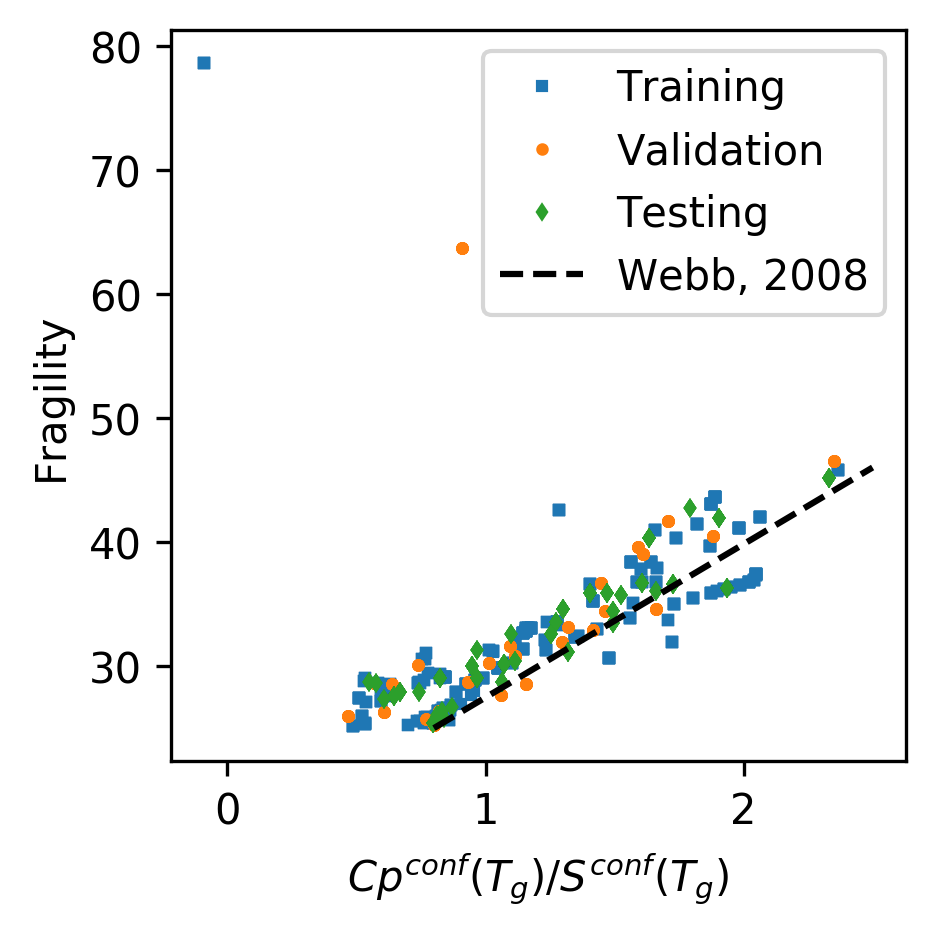

In [27]:
plt.figure(figsize=(3.22,3.22),dpi=300)
# Train

Cpconf = neuralmodel.predict("ap_calc",ds.x_visco_train).mean(axis=1) + neuralmodel.predict("b_calc",ds.x_visco_train).mean(axis=1)* neuralmodel.predict("tg",ds.x_visco_train).mean(axis=1)
Cp_S = Cpconf/neuralmodel.predict("sctg",ds.x_visco_train).mean(axis=1)

plt.plot(Cp_S,neuralmodel.predict("fragility",ds.x_visco_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Training")

# Valid
Cpconf = neuralmodel.predict("ap_calc",ds.x_visco_valid).mean(axis=1) + neuralmodel.predict("b_calc",ds.x_visco_valid).mean(axis=1)* neuralmodel.predict("tg",ds.x_visco_valid).mean(axis=1)
Cp_S = Cpconf/neuralmodel.predict("sctg",ds.x_visco_valid).mean(axis=1)

plt.plot(Cp_S,neuralmodel.predict("fragility",ds.x_visco_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Validation")

# Test
Cpconf = neuralmodel.predict("ap_calc",ds.x_visco_test).mean(axis=1) + neuralmodel.predict("b_calc",ds.x_visco_test).mean(axis=1)* neuralmodel.predict("tg",ds.x_visco_test).mean(axis=1)
Cp_S = Cpconf/neuralmodel.predict("sctg",ds.x_visco_test).mean(axis=1)

plt.plot(Cp_S,neuralmodel.predict("fragility",ds.x_visco_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Testing")

plt.plot([0.8, 2.5],[25., 46],"k--",label="Webb, 2008")

plt.xlabel(r"$Cp^{conf}(T_g)/S^{conf}(T_g)$")
plt.ylabel("Fragility")

plt.legend()
plt.tight_layout()
plt.savefig("./figures/SupplementaryFigure_mVSCpS.png")

# For presentation

I did the plot below to include it in PPT for talks

In [28]:
plt.figure(figsize=(6.44,6.44))

plt.subplot(2,2,1)

plt.plot(x_raman_shift,raman_valid_predictions[0,:],color="C1",label="Model")
plt.plot(x_raman_shift,ds.y_raman_valid[0,:].detach().numpy(),"k-",label="Data")


plt.xlabel("Raman shift, cm$^{-1}$")
plt.ylabel("Intensity, a. u.")

plt.legend(loc="best")

plt.subplot(2,2,2)
plt.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("tg",X_gen).mean(axis=1), s=1,c=CLR(X_gen.detach().numpy()))

plt.xlim(-0.2,4.5)
plt.xlabel("$R_{Raman}$")
plt.ylabel(r"Glass transition temperature T$_{g}$, K$^{-1}$")

plt.subplot(2,2,3)
plt.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("sctg",X_gen).mean(axis=1), s=1,c=CLR(X_gen.detach().numpy()))

plt.xlim(-0.2,4.5)
plt.ylim(4,16)
plt.xlabel("$R_{Raman}$")
plt.ylabel(r"S$^{conf}$(T$_{g}$), J mol$^{-1}$ K$^{-1}$")

plt.subplot(2,2,4)
plt.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("fragility",X_gen).mean(axis=1), s=1,c=CLR(X_gen.detach().numpy()))

plt.xlim(-0.2,4.5)
#plt.ylim(18,47)
plt.xlabel("$R_{Raman}$")
plt.ylabel(r"Melt fragility $m$")

#plt.ylim(5,14)

plt.tight_layout()
plt.savefig("./figures/Pres_FigRaman.pdf")

# Maps of glass properties: Tg, density, refractive index

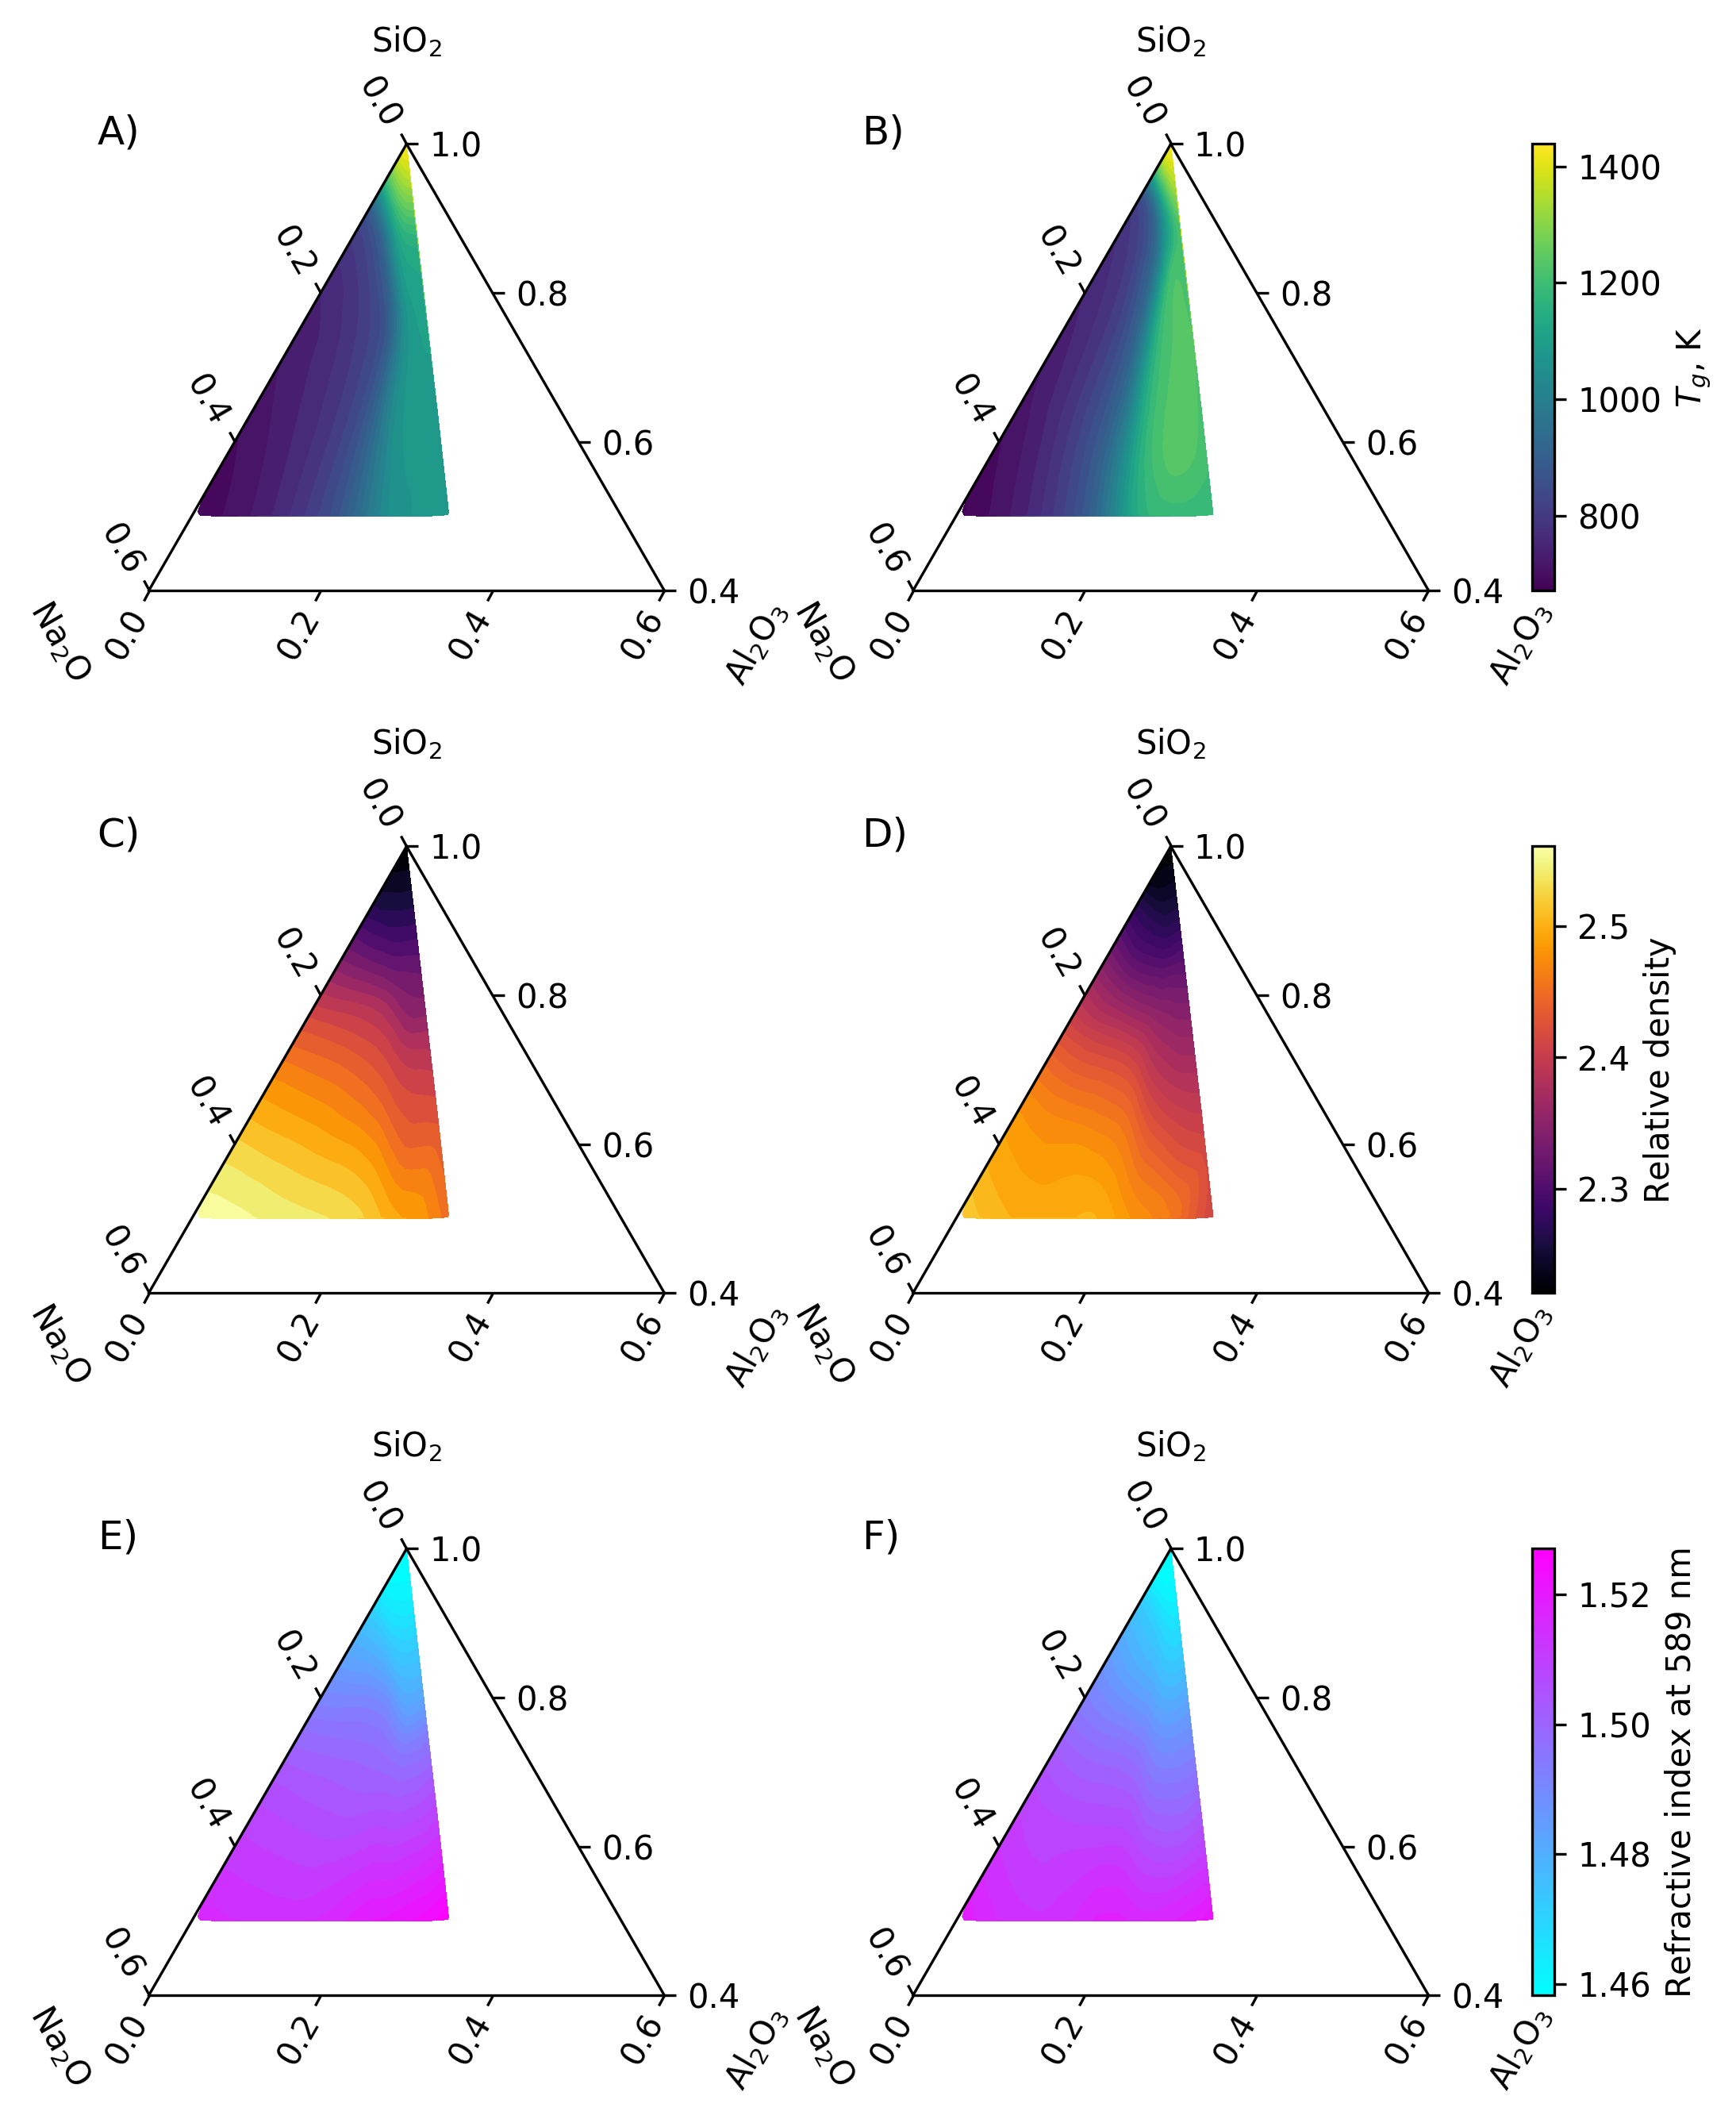

In [29]:
plt.figure(figsize=(9,9), dpi=300)

# grabing the predictions in NAS and KAS
tg_NAS = neuralmodel.predict("tg",X_gen_NAS).mean(axis=1)
tg_KAS = neuralmodel.predict("tg",X_gen_KAS).mean(axis=1)
tg_all = neuralmodel.predict("tg",X_gen_all).mean(axis=1)

d_NAS = neuralmodel.predict("density",X_gen_NAS).mean(axis=1)
d_KAS = neuralmodel.predict("density",X_gen_KAS).mean(axis=1)
d_all = neuralmodel.predict("density",X_gen_all).mean(axis=1)

n_NAS = neuralmodel.predict("sellmeier",X_gen_NAS,lbd=np.ones((len(X_gen_NAS),1))*0.589).mean(axis=1)
n_KAS = neuralmodel.predict("sellmeier",X_gen_KAS,lbd=np.ones((len(X_gen_KAS),1))*0.589).mean(axis=1)
n_all = neuralmodel.predict("sellmeier",X_gen_all,lbd=np.ones((len(X_gen_all),1))*0.589).mean(axis=1)

# choose colormaps
c_m1 = matplotlib.cm.viridis 
c_m2 = matplotlib.cm.inferno 
c_m3 = matplotlib.cm.cool 

# color normalisation
norm1 = matplotlib.colors.Normalize(vmin=np.min(tg_all), vmax=np.max(tg_all))
norm2 = matplotlib.colors.Normalize(vmin=np.min(d_all), vmax=np.max(d_all))
norm3 = matplotlib.colors.Normalize(vmin=np.min(n_all), vmax=np.max(n_all))

#### Scalar Mappables for color bars
s_tg = matplotlib.cm.ScalarMappable(cmap=c_m1, 
                                   norm=norm1) # create a ScalarMappable and initialize a data structure
s_d = matplotlib.cm.ScalarMappable(cmap=c_m2, 
                                   norm=norm2)
s_n = matplotlib.cm.ScalarMappable(cmap=c_m3, 
                                   norm=norm3)
####
#### NAS Tg TERNARY PLOT
####
ax = plt.subplot(3,2,1,projection='ternary')

# data are plotted
ax.tricontourf(X_gen_NAS_rec.sio2,X_gen_NAS_rec.na2o,X_gen_NAS_rec.al2o3, 
                tg_NAS, 
                levels=30, cmap=c_m1, norm=norm1)

ax.set_tlabel('SiO$_2$')
ax.set_llabel('Na$_2$O')
ax.set_rlabel('Al$_2$O$_3$')

# Limits (see previous examples)
ax.set_ternary_lim(
    0.4, 1.0,  # tmin, tmax
    0.0, 0.6,  # lmin, lmax
    0.0, 0.6,  # rmin, rmax
)

ax.annotate("A)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)

#plt.tight_layout()

####
#### KAS Tg TERNARY PLOT
####
ax2 = plt.subplot(3,2,2,projection='ternary')

# data are plotted
ax2.tricontourf(X_gen_KAS_rec.sio2,X_gen_KAS_rec.k2o,X_gen_KAS_rec.al2o3, 
                tg_KAS, 
                levels=30, cmap=c_m1, norm=norm1)

ax2.set_tlabel('SiO$_2$')
ax2.set_llabel('Na$_2$O')
ax2.set_rlabel('Al$_2$O$_3$')

# Limits (see previous examples)
ax2.set_ternary_lim(
    0.4, 1.0,  # tmin, tmax
    0.0, 0.6,  # lmin, lmax
    0.0, 0.6,  # rmin, rmax
)

ax2.annotate("B)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)

plt.tight_layout()

####
#### NAS Density TERNARY PLOT
####
ax3 = plt.subplot(3,2,3,projection='ternary')

# data are plotted
ax3.tricontourf(X_gen_NAS_rec.sio2,X_gen_NAS_rec.na2o,X_gen_NAS_rec.al2o3, 
                d_NAS, 
                levels=30, cmap=c_m2, norm=norm2)

ax3.set_tlabel('SiO$_2$')
ax3.set_llabel('Na$_2$O')
ax3.set_rlabel('Al$_2$O$_3$')

# Limits (see previous examples)
ax3.set_ternary_lim(
    0.4, 1.0,  # tmin, tmax
    0.0, 0.6,  # lmin, lmax
    0.0, 0.6,  # rmin, rmax
)

ax3.annotate("C)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)

#plt.tight_layout()

####
#### KAS Density TERNARY PLOT
####
ax4 = plt.subplot(3,2,4,projection='ternary')

# data are plotted
ax4.tricontourf(X_gen_KAS_rec.sio2,X_gen_KAS_rec.k2o,X_gen_KAS_rec.al2o3, 
                d_KAS, 
                levels=30, cmap=c_m2, norm=norm2)

ax4.set_tlabel('SiO$_2$')
ax4.set_llabel('Na$_2$O')
ax4.set_rlabel('Al$_2$O$_3$')

# Limits (see previous examples)
ax4.set_ternary_lim(
    0.4, 1.0,  # tmin, tmax
    0.0, 0.6,  # lmin, lmax
    0.0, 0.6,  # rmin, rmax
)

ax4.annotate("D)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)

plt.tight_layout()

####
#### NAS Refractive Index TERNARY PLOT
####
ax5 = plt.subplot(3,2,5,projection='ternary')

# data are plotted
ax5.tricontourf(X_gen_NAS_rec.sio2,X_gen_NAS_rec.na2o,X_gen_NAS_rec.al2o3, 
                n_NAS, 
                levels=30, cmap=c_m3, norm=norm3)

ax5.set_tlabel('SiO$_2$')
ax5.set_llabel('Na$_2$O')
ax5.set_rlabel('Al$_2$O$_3$')

# Limits (see previous examples)
ax5.set_ternary_lim(
    0.4, 1.0,  # tmin, tmax
    0.0, 0.6,  # lmin, lmax
    0.0, 0.6,  # rmin, rmax
)

ax5.annotate("E)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)

#plt.tight_layout()

####
#### KAS Refractive Index TERNARY PLOT
####
ax6 = plt.subplot(3,2,6,projection='ternary')

# data are plotted
ax6.tricontourf(X_gen_KAS_rec.sio2,X_gen_KAS_rec.k2o,X_gen_KAS_rec.al2o3, 
                n_KAS, 
                levels=30, cmap=c_m3, norm=norm3)

ax6.set_tlabel('SiO$_2$')
ax6.set_llabel('Na$_2$O')
ax6.set_rlabel('Al$_2$O$_3$')

# Limits (see previous examples)
ax6.set_ternary_lim(
    0.4, 1.0,  # tmin, tmax
    0.0, 0.6,  # lmin, lmax
    0.0, 0.6,  # rmin, rmax
)

ax6.annotate("F)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)

plt.tight_layout(w_pad=1.5)

####
#### Colorbar for the two subplots
####
cbar_1 = plt.colorbar(mappable=s_tg,ax=[ax,ax2],orientation="vertical",pad=0.05)
cbar_1.set_label(r"$T_g$, K")

cbar_2 = plt.colorbar(mappable=s_d,ax=[ax3,ax4],orientation="vertical",pad=0.05)
cbar_2.set_label(r"Relative density")

cbar_3 = plt.colorbar(mappable=s_n,ax=[ax5,ax6],orientation="vertical",pad=0.05)
cbar_3.set_label(r"Refractive index at 589 nm")

plt.savefig("./figures/Supplementary_Tg_maps.png",bbox_inches='tight')

# Supplementary Figure : Map of melt fragility

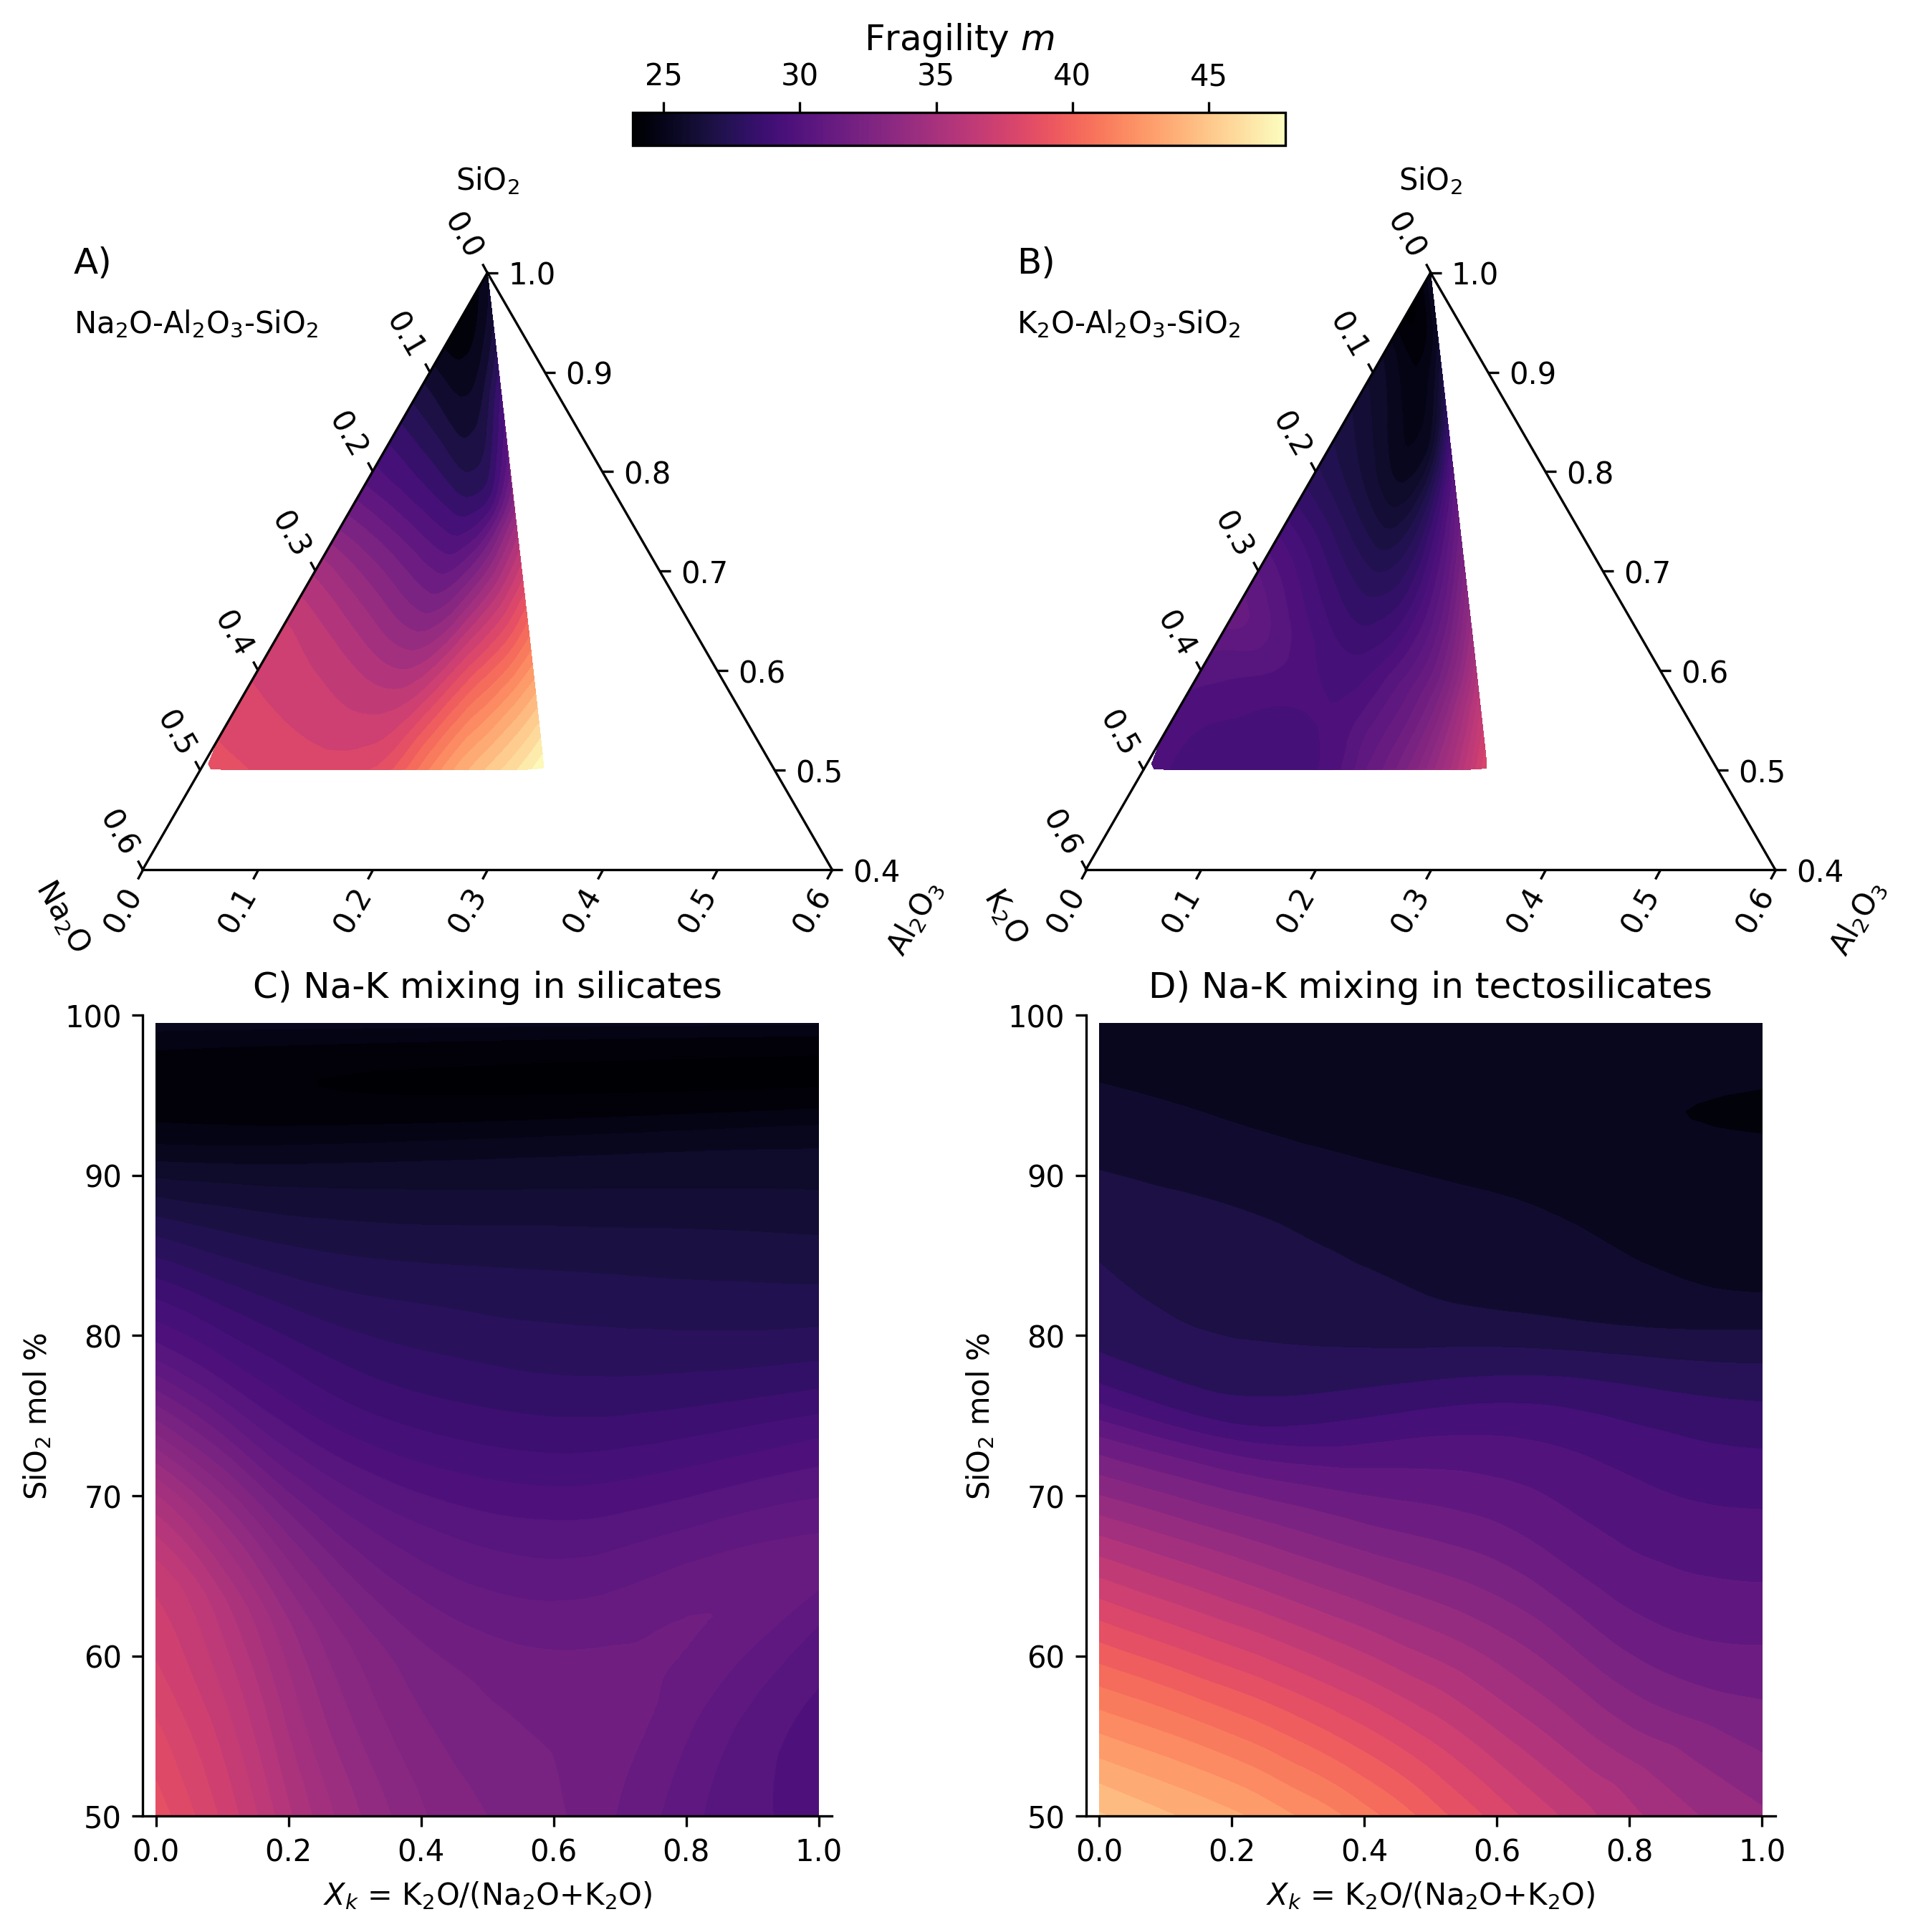

In [30]:
####
#### GENERATING ENTROPY
####

# grabing the entropies along NS/KS
fragility_NAS = neuralmodel.predict("fragility",X_gen_NAS).mean(axis=1)
fragility_KAS = neuralmodel.predict("fragility",X_gen_KAS).mean(axis=1)
fragility_all = neuralmodel.predict("fragility",X_gen_all).mean(axis=1)

# grabing the entropies for the mixtures
fragility_RS_Xk = neuralmodel.predict("fragility",X_gen_RS_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
fragility_R3_Xk = neuralmodel.predict("fragility",X_gen_R3_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
fragility_R1_Xk = neuralmodel.predict("fragility",X_gen_R1_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)

####
#### COLOR CALCULATIONS
####

trig_color_plot = fragility_all # for the colors > same scale 

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(trig_color_plot),
    vmax=np.max(trig_color_plot))

c_m = matplotlib.cm.magma # choose a colormap
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm) # create a ScalarMappable and initialize a data structure

####
#### FIGURE DECLARATION
####

plt.figure(figsize=(9,9),dpi=300)

####
#### TERNARY PLOT NAS
####

ax = plt.subplot(2,2,1,projection='ternary')

# data are plotted
ax.tricontourf(X_gen_NAS_rec.sio2,X_gen_NAS_rec.na2o,X_gen_NAS_rec.al2o3, 
                fragility_NAS, 
                levels=30, cmap=c_m, norm=norm)

ax.set_tlabel('SiO$_2$')
ax.set_llabel('Na$_2$O')
ax.set_rlabel('Al$_2$O$_3$')

# Using ``ternary_lim``, you can limit the range of ternary axes.
# Be sure about the consistency; the limit values must satisfy:
# tmax + lmin + rmin = tmin + lmax + rmin = tmin + lmin + rmax = ternary_scale
ax.set_ternary_lim(
    0.4, 1.0,  # tmin, tmax
    0.0, 0.6,  # lmin, lmax
    0.0, 0.6,  # rmin, rmax
)

ax.annotate("A)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)
ax.annotate("Na$_2$O-Al$_2$O$_3$-SiO$_2$", xy=(-0.1,0.9), xycoords="axes fraction")

####
#### TERNARY PLOT KAS
####

ax2 = plt.subplot(2,2,2,projection='ternary')

ax2.tricontourf(X_gen_KAS_rec.sio2,X_gen_KAS_rec.k2o,X_gen_KAS_rec.al2o3, 
                fragility_KAS, 
                levels=30, cmap=c_m, norm=norm)

ax2.set_tlabel('SiO$_2$')
ax2.set_llabel('K$_2$O')
ax2.set_rlabel('Al$_2$O$_3$')

# Using ``ternary_lim``, you can limit the range of ternary axes.
# Be sure about the consistency; the limit values must satisfy:
# tmax + lmin + rmin = tmin + lmax + rmin = tmin + lmin + rmax = ternary_scale
ax2.set_ternary_lim(
    0.4, 1.0,  # tmin, tmax
    0.0, 0.6,  # lmin, lmax
    0.0, 0.6,  # rmin, rmax
)

ax2.annotate("B)", xy=(-0.1,1.0), xycoords="axes fraction",fontsize=12)
ax2.annotate("K$_2$O-Al$_2$O$_3$-SiO$_2$", xy=(-0.1,0.9), xycoords="axes fraction")

####
#### XK along near tectosilicate joint
####

ax3= plt.subplot(2,2,3)
tc1 = ax3.tricontourf(X_gen_RS_Xk_rec.loc[:,"xk"], 
                X_gen_RS_Xk_rec.loc[:,"sio2"]*100, 
                fragility_RS_Xk, 
                levels=30, cmap=c_m, norm=norm)

ax3.set_xlim(-0.02,1.02)
ax3.set_ylim(50,100.)

plt.xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
plt.ylabel(r"SiO$_2$ mol %")

# Hide the right and top spines
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

# Title
ax3.set_title("C) Na-K mixing in silicates", loc='center')

####
#### XK along near tectosilicate joint
####
ax4= plt.subplot(2,2,4)
tc1 = plt.tricontourf(X_gen_R1_Xk_rec.loc[:,"xk"], 
                X_gen_R1_Xk_rec.loc[:,"sio2"]*100, 
                fragility_R1_Xk, 
                levels=30, cmap=c_m, norm=norm)
#
#ax4.scatter(X_gen_R1_Xk_rec.loc[:,"xk"],X_gen_R1_Xk_rec.loc[:,"sio2"]*100,s=1,c="k", cmap="RdBu_r")
ax4.set_xlim(-0.02,1.02)
ax4.set_ylim(50,100.)

plt.xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
plt.ylabel(r"SiO$_2$ mol %")

# Hide the right and top spines
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

# Title
ax4.set_title("D) Na-K mixing in tectosilicates", loc='center')

####
#### Layout adjustment
####

# This should be done befor color bar, it's actually tricky...
plt.tight_layout(h_pad=0.1, w_pad=1)

####
#### colorbar
####

cbar_0 = plt.colorbar(mappable=s_m, ax=[ax,ax2],shrink=0.4,location='top',anchor=(0.5,1.0))
cbar_0.set_label(r"Fragility $m$", fontsize=12)

plt.savefig("./figures/Supplementary_fragility.png",bbox_inches="tight")